<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Best_learning_rate_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [3]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

# Data Preprocessing

In [4]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [5]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [6]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [8]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [10]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [11]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

# Hourly resampled data

In [12]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()
daily_resampled = df_imputed.resample('D').mean()

## EDA

In [13]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


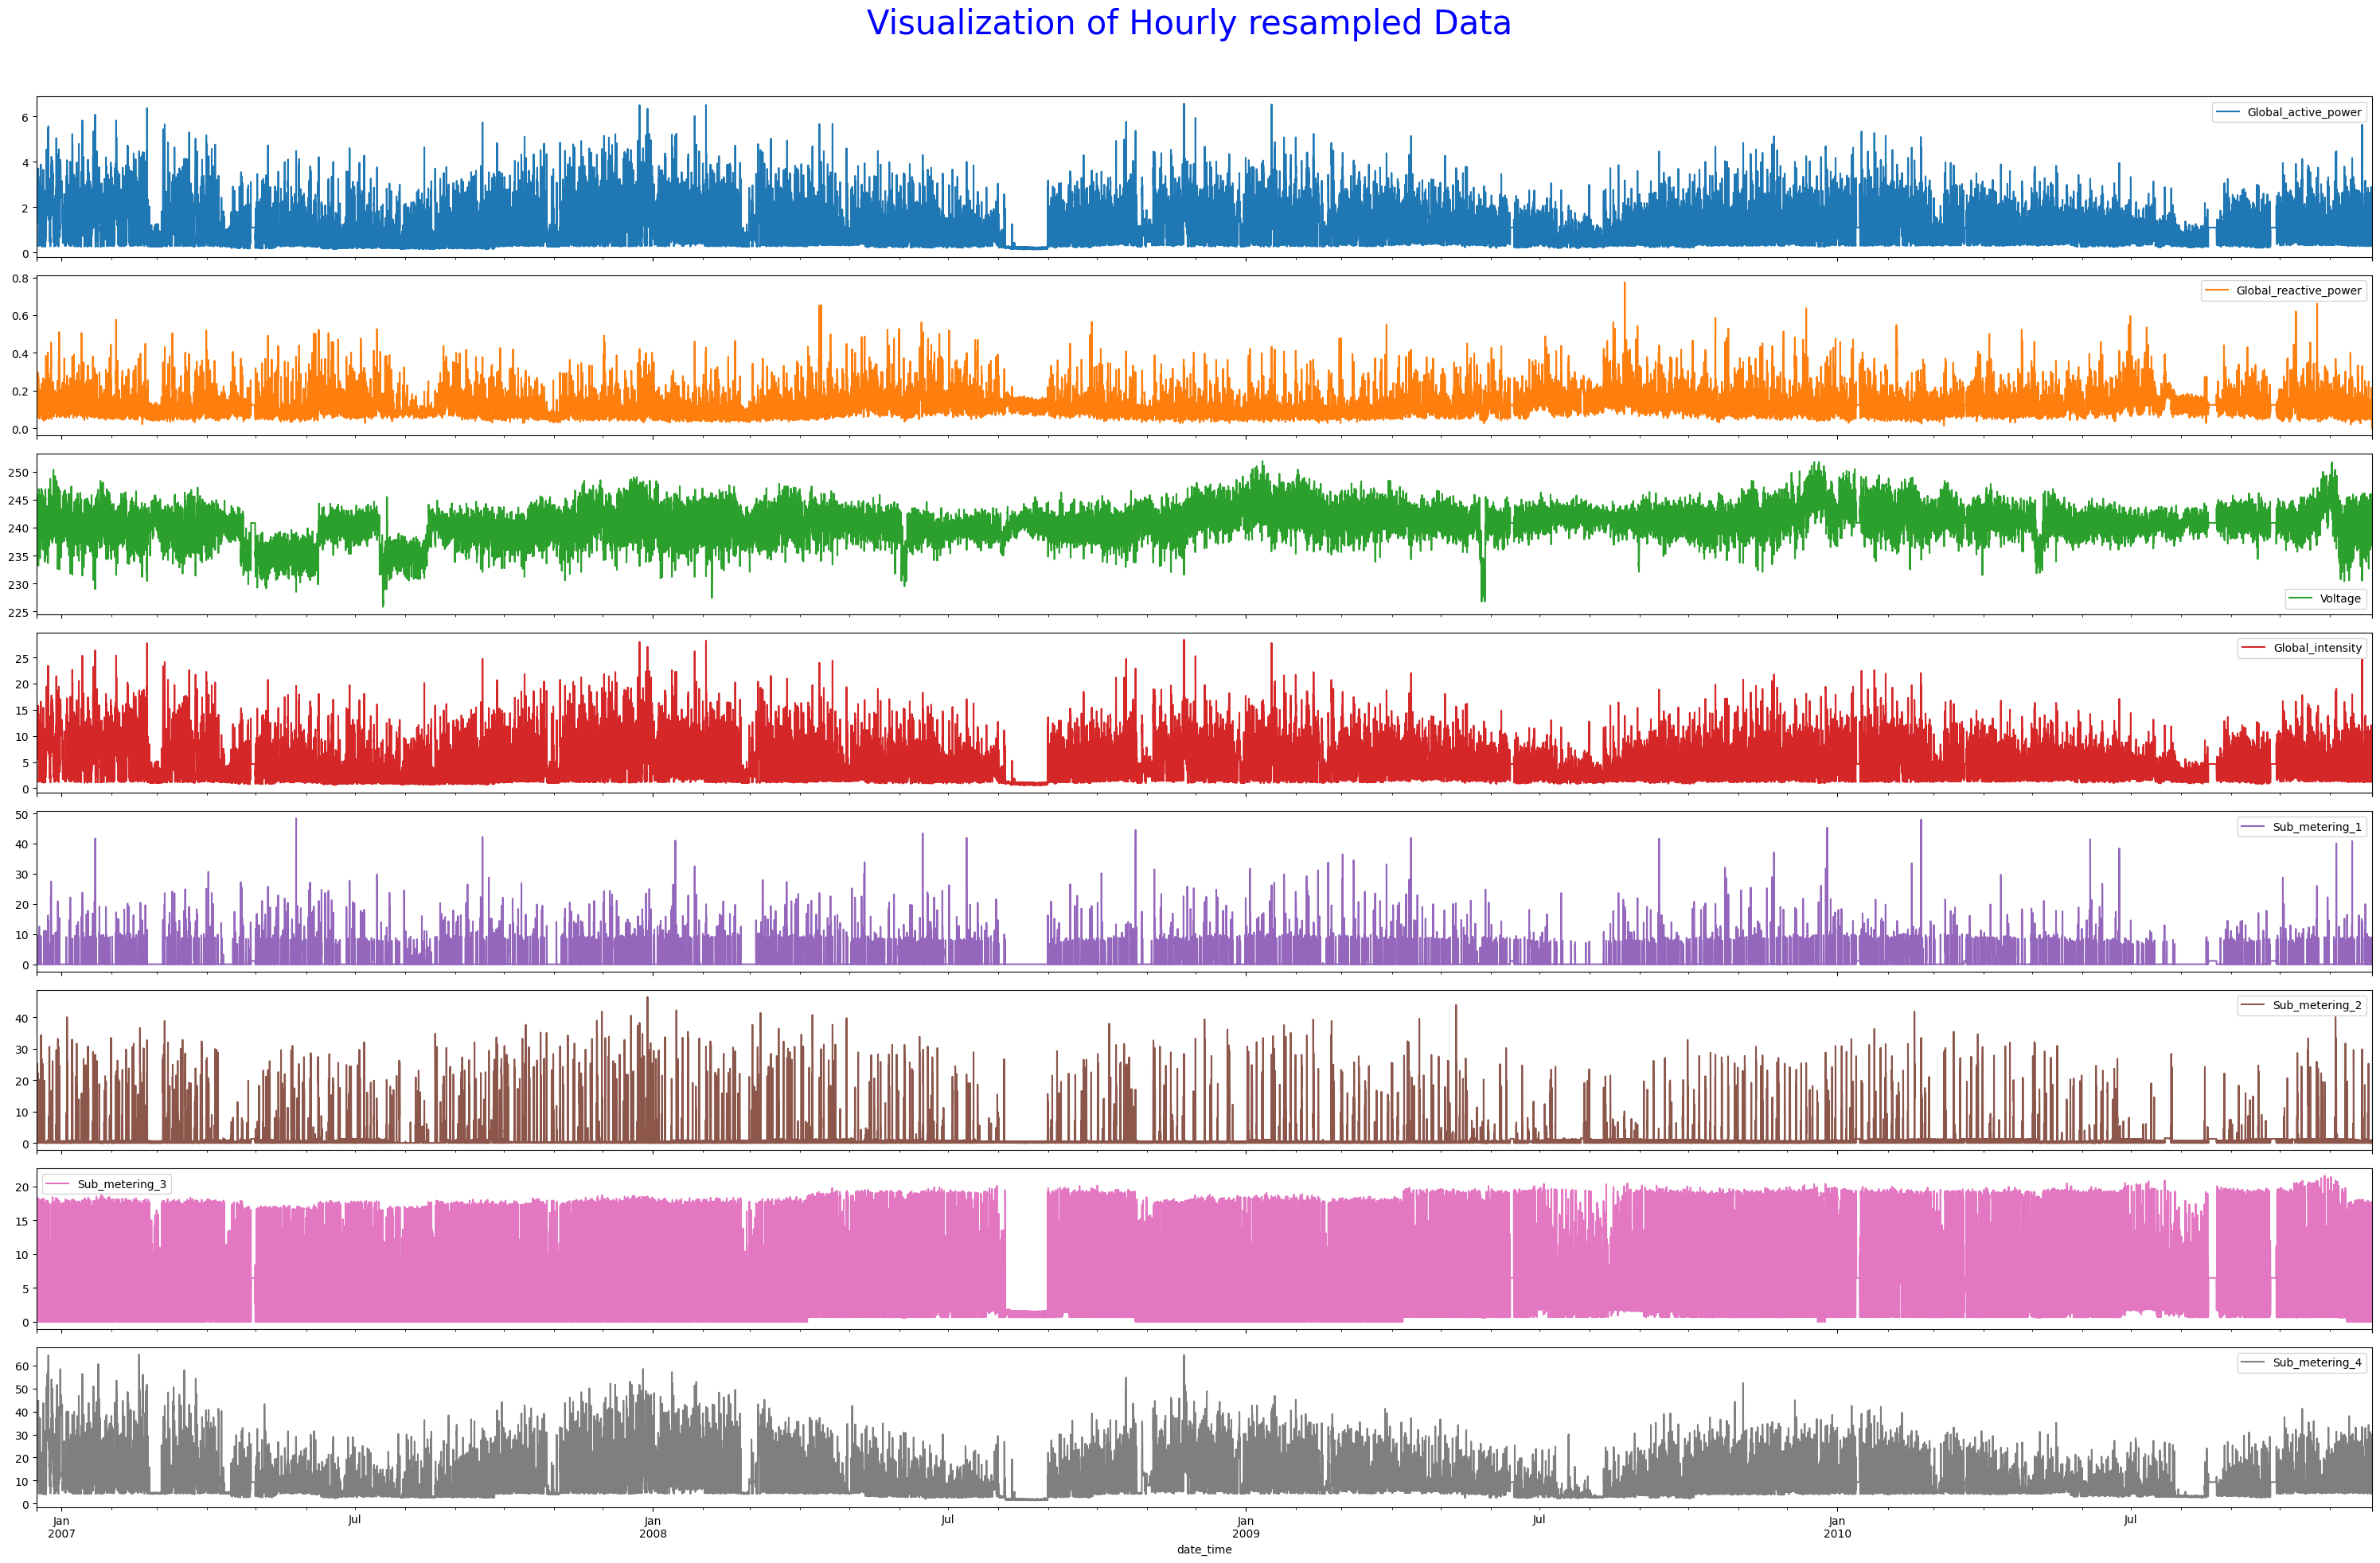

 

************************************************ Hourly Resampled distribution Plot **************************************************



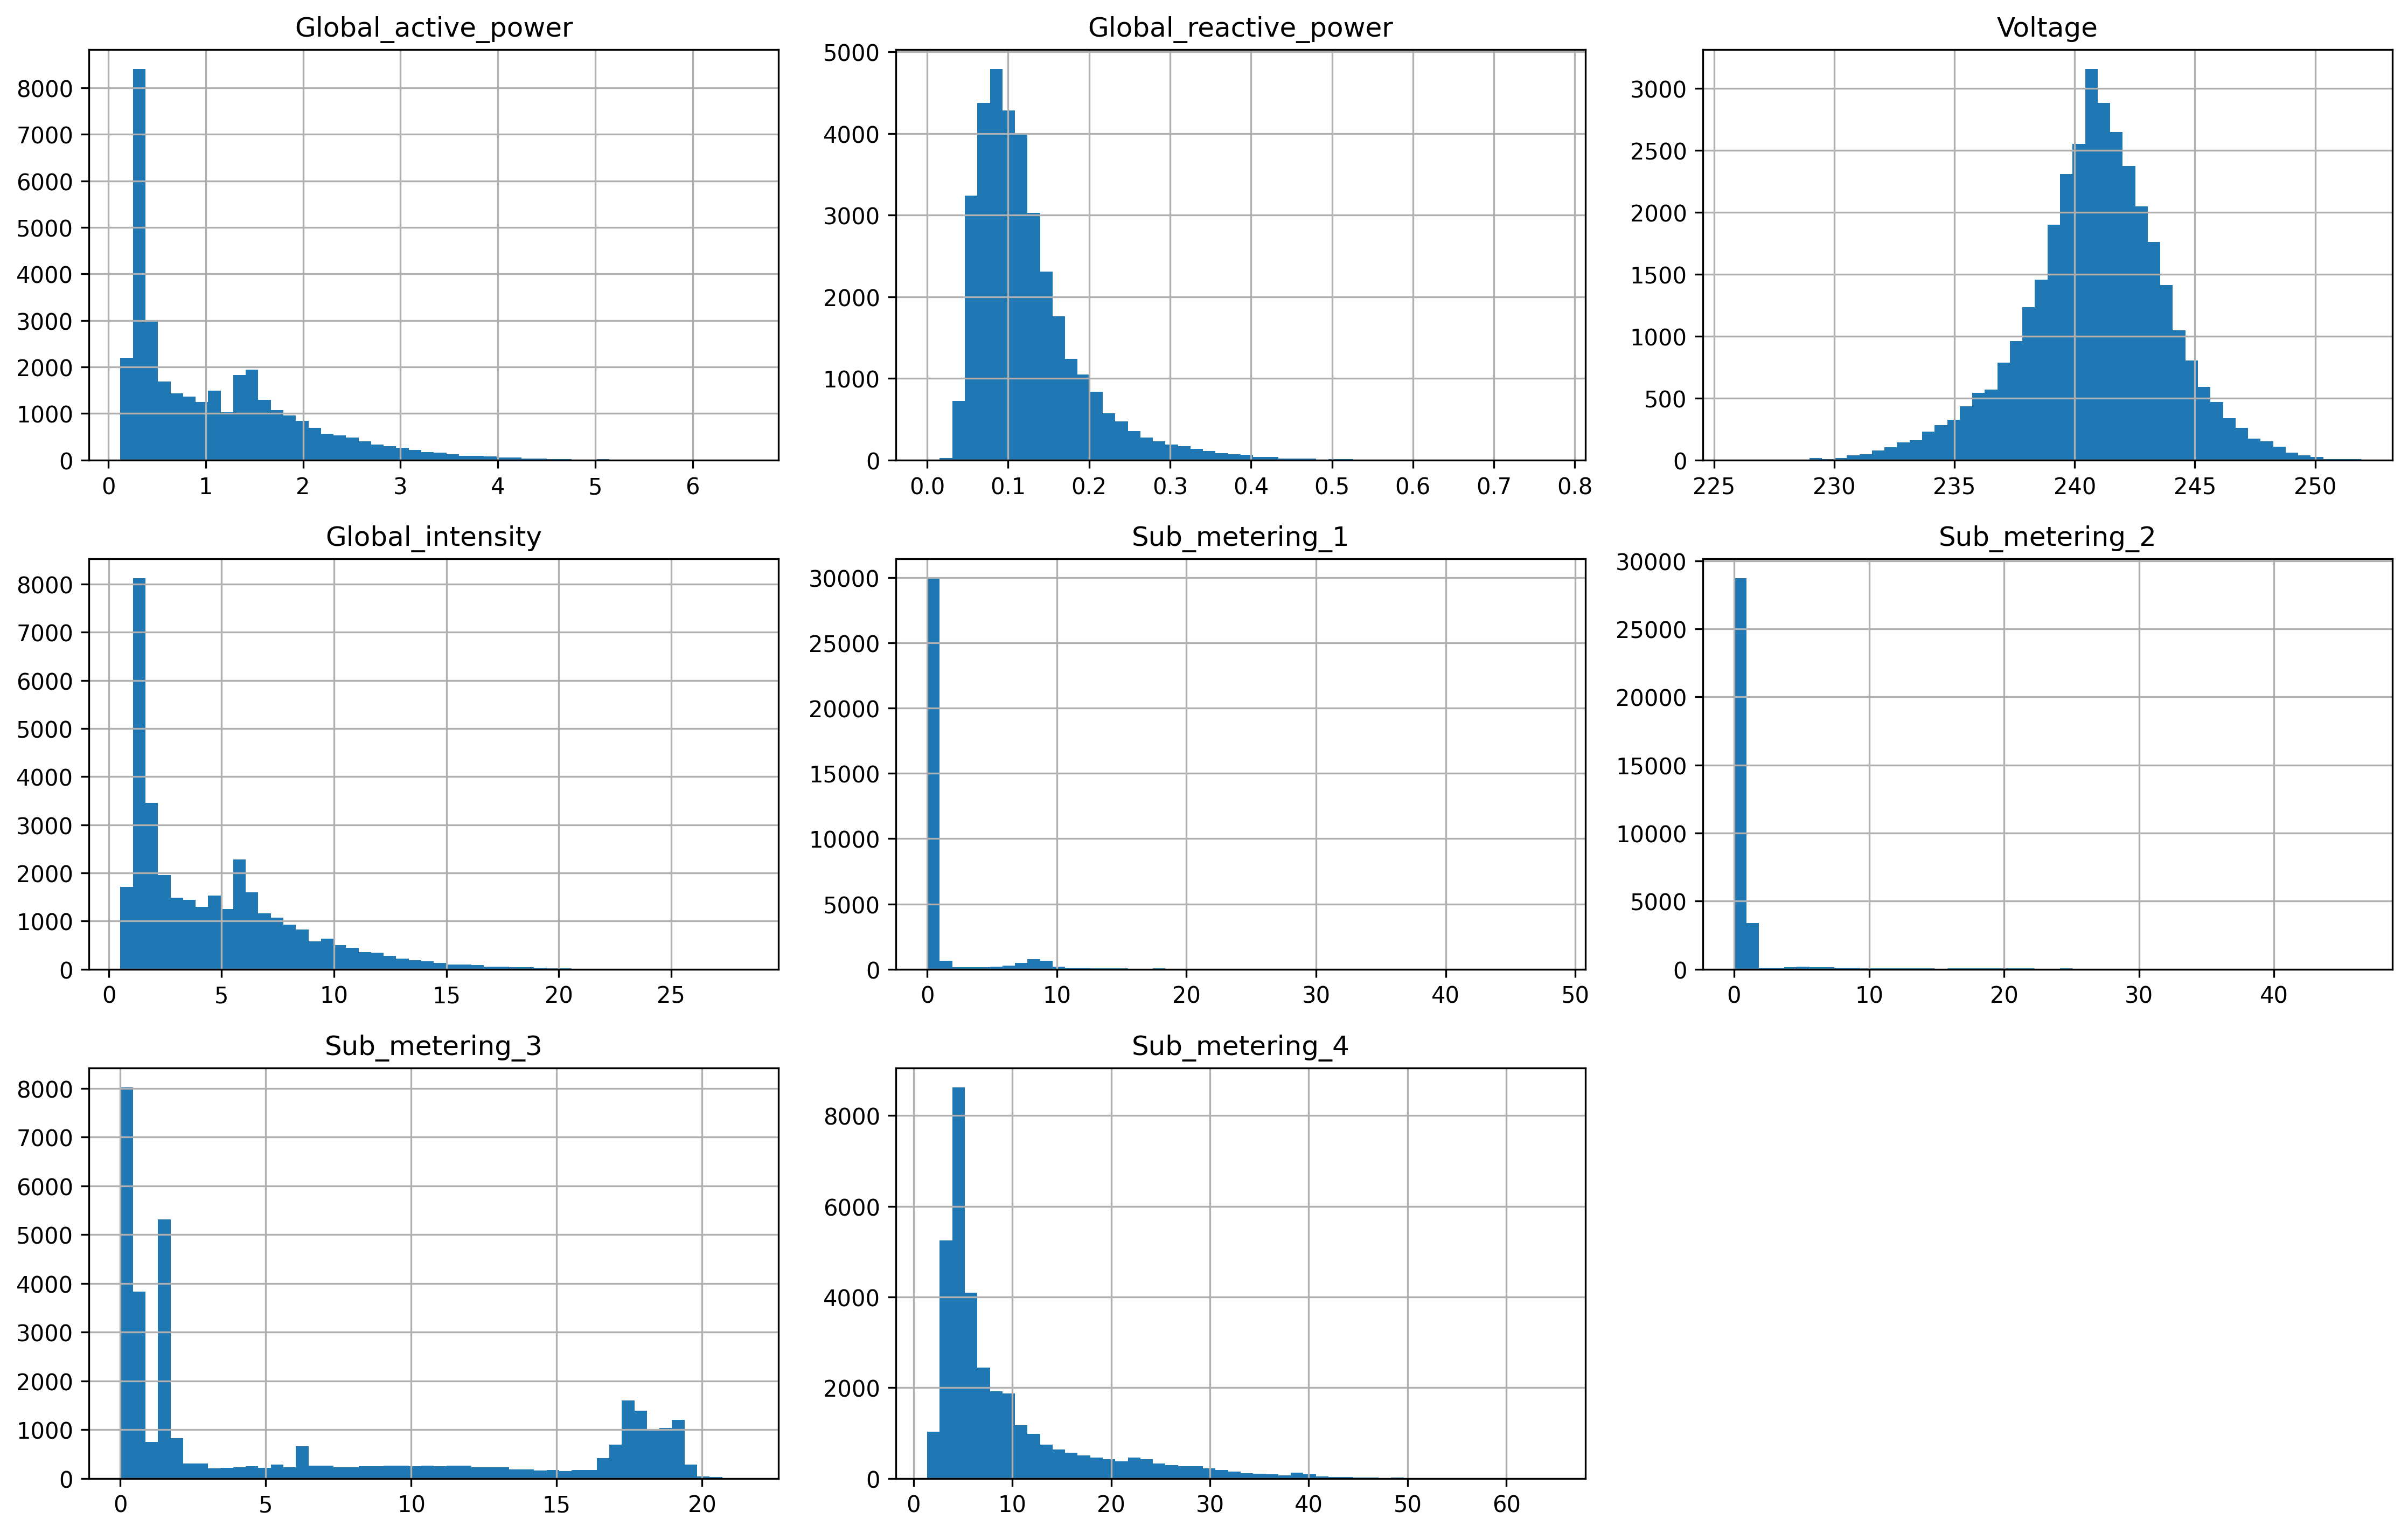

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



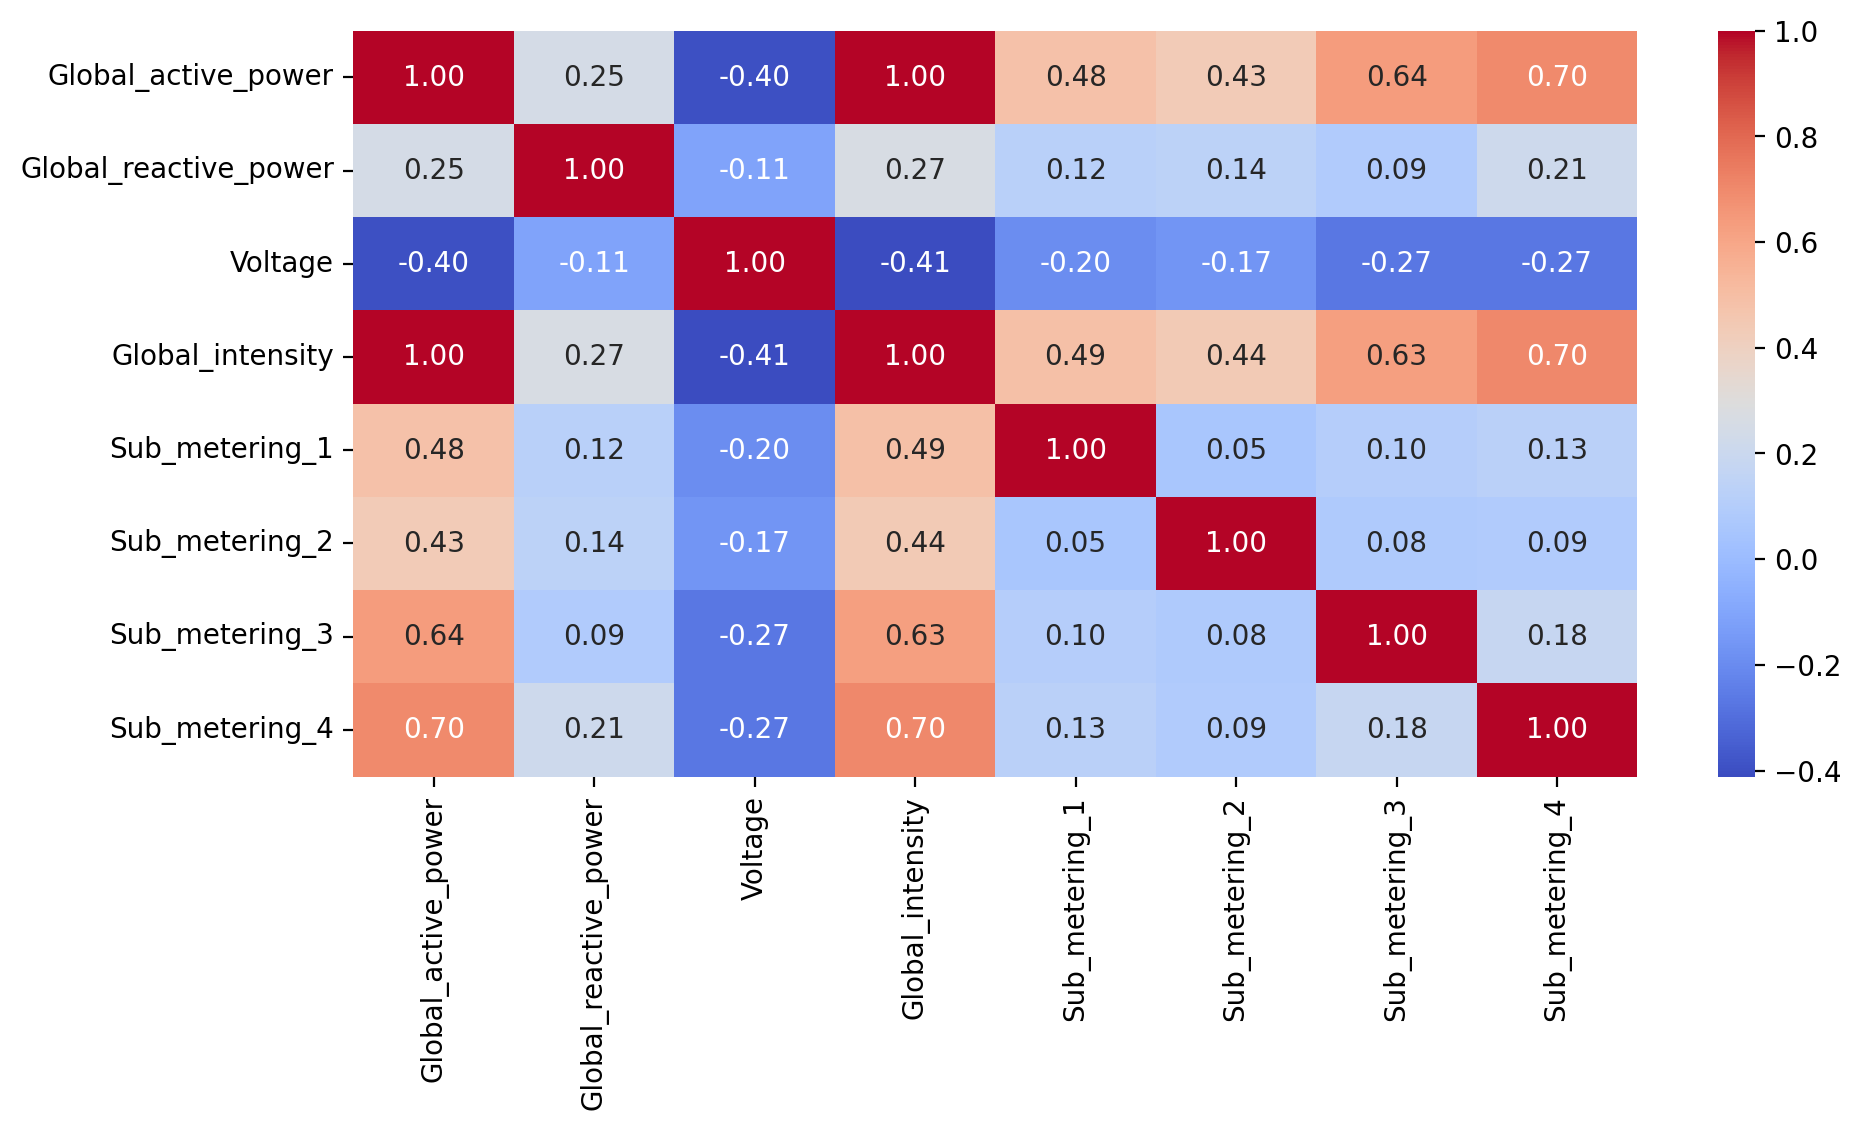

In [14]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [15]:
df1 = hourly_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df1

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                            
2006-12-16 17:00:00             0.0        0.527778       16.861111  
2006-12-16 18:00:00             0.0        6.716667       16.866667  
2006-12-16 19:00:00             0.0        1.433333       16.683333  
2006-12-16 20:00:00             0.0        0.000000       16.783333  
2006-12-16 21:00:00             0.0        0.416667       17.216667  
...                             ...             ...             ...  
2010-11-26 17:00:00             0.0        0.000000       12.866667  
2010-11-26 18:00:00             0.0        0.000000        0.000000  
2010-11-26 19:00:00             0.0        0.066667        0.000000  
2010-11-26 20:00:00             0.0        1.066667        0.000000  
2010-11-26 21:00:00             0.0        0.000000        0.000000  

[34589 rows x 6 columns]

## Data Normalization

## LSTM-1 Adam(lr=0.01) seq=24 epochs=50 batch_size=32

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
865/865 - 8s - 9ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 2/50
865/865 - 5s - 5ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 3/50
865/865 - 4s - 5ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 4/50
865/865 - 4s - 4ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/50
865/865 - 4s - 4ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 6/50
865/865 - 8s - 9ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 7/50
865/865 - 4s - 4ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 8/50
865/865 - 7s - 8ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/50
865/865 - 4s - 4ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 10/50
865/865 - 8s - 9ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 11/50
865/865 - 9s - 10ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 12/50
865/865 - 6s - 7ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 13/50
865/865 - 10s - 12ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 14/50
865/865 - 9s - 10ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 15/50
865/865 - 6s 

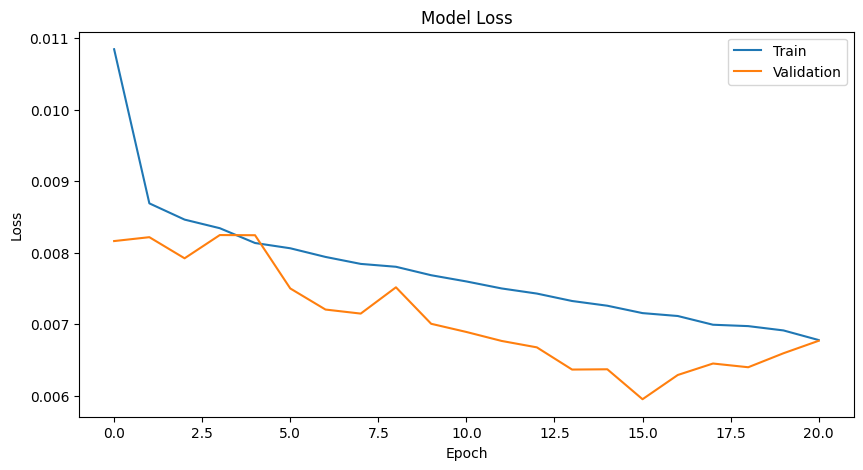

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train MAE: 0.42757311353843497
Train MSE: 0.31963704167371876
Train RMSE: 0.5653645210602791

Test MAE: 0.40365756975280404
Test MSE: 0.28044636379621113
Test RMSE: 0.5295718683957931


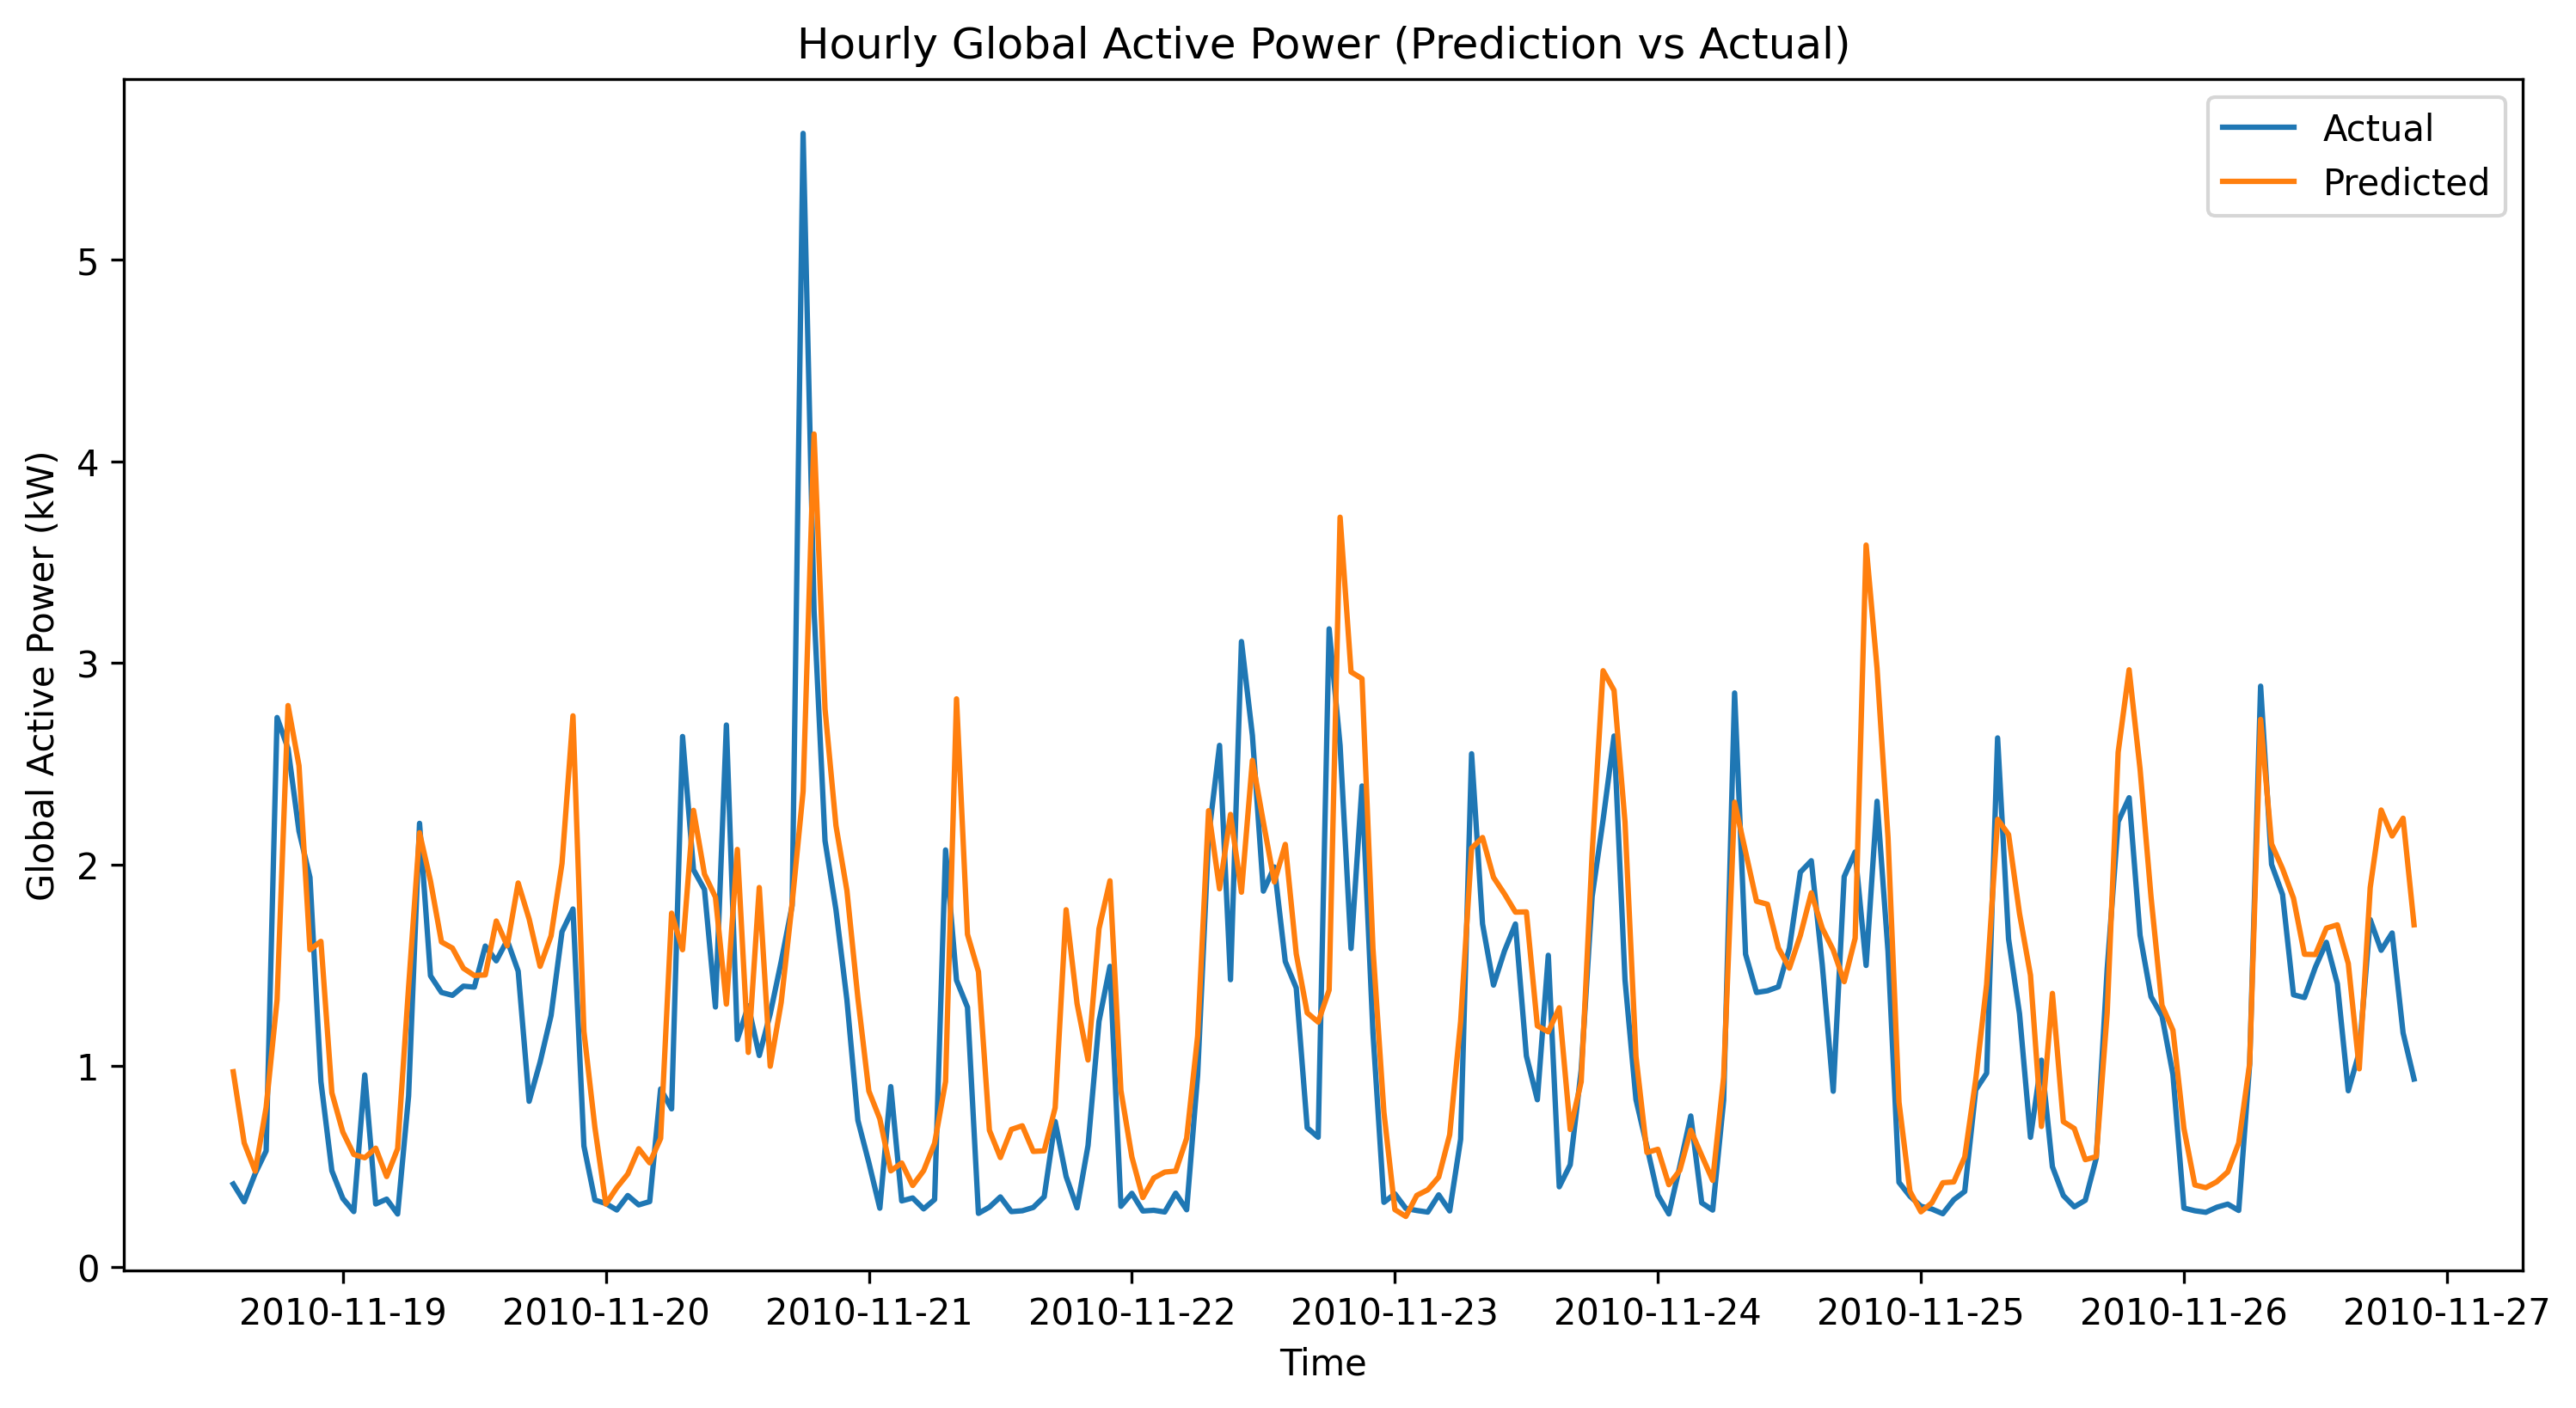

In [17]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-2 Adam(lr=0.001) seq=24 epochs=50 batch_size=32

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
865/865 - 7s - 8ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 2/50
865/865 - 5s - 6ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 3/50
865/865 - 4s - 4ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 4/50
865/865 - 4s - 4ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 5/50
865/865 - 7s - 8ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 6/50
865/865 - 8s - 10ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 7/50
865/865 - 5s - 6ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 8/50
865/865 - 4s - 4ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 9/50
865/865 - 4s - 4ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 10/50
865/865 - 6s - 7ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 11/50
865/865 - 4s - 5ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 12/50
865/865 - 4s - 4ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 13/50
865/865 - 6s - 7ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 14/50
865/865 - 8s - 9ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 15/50
865/865 - 4s - 5

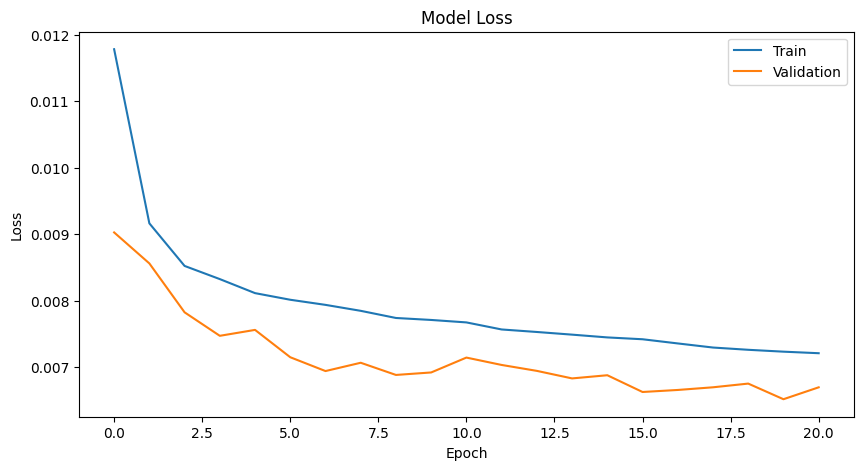

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.44064287186470774
Train MSE: 0.34145034531851387
Train RMSE: 0.5843375268785275

Test MAE: 0.4008964675612514
Test MSE: 0.27744313826154915
Test RMSE: 0.5267287141039011


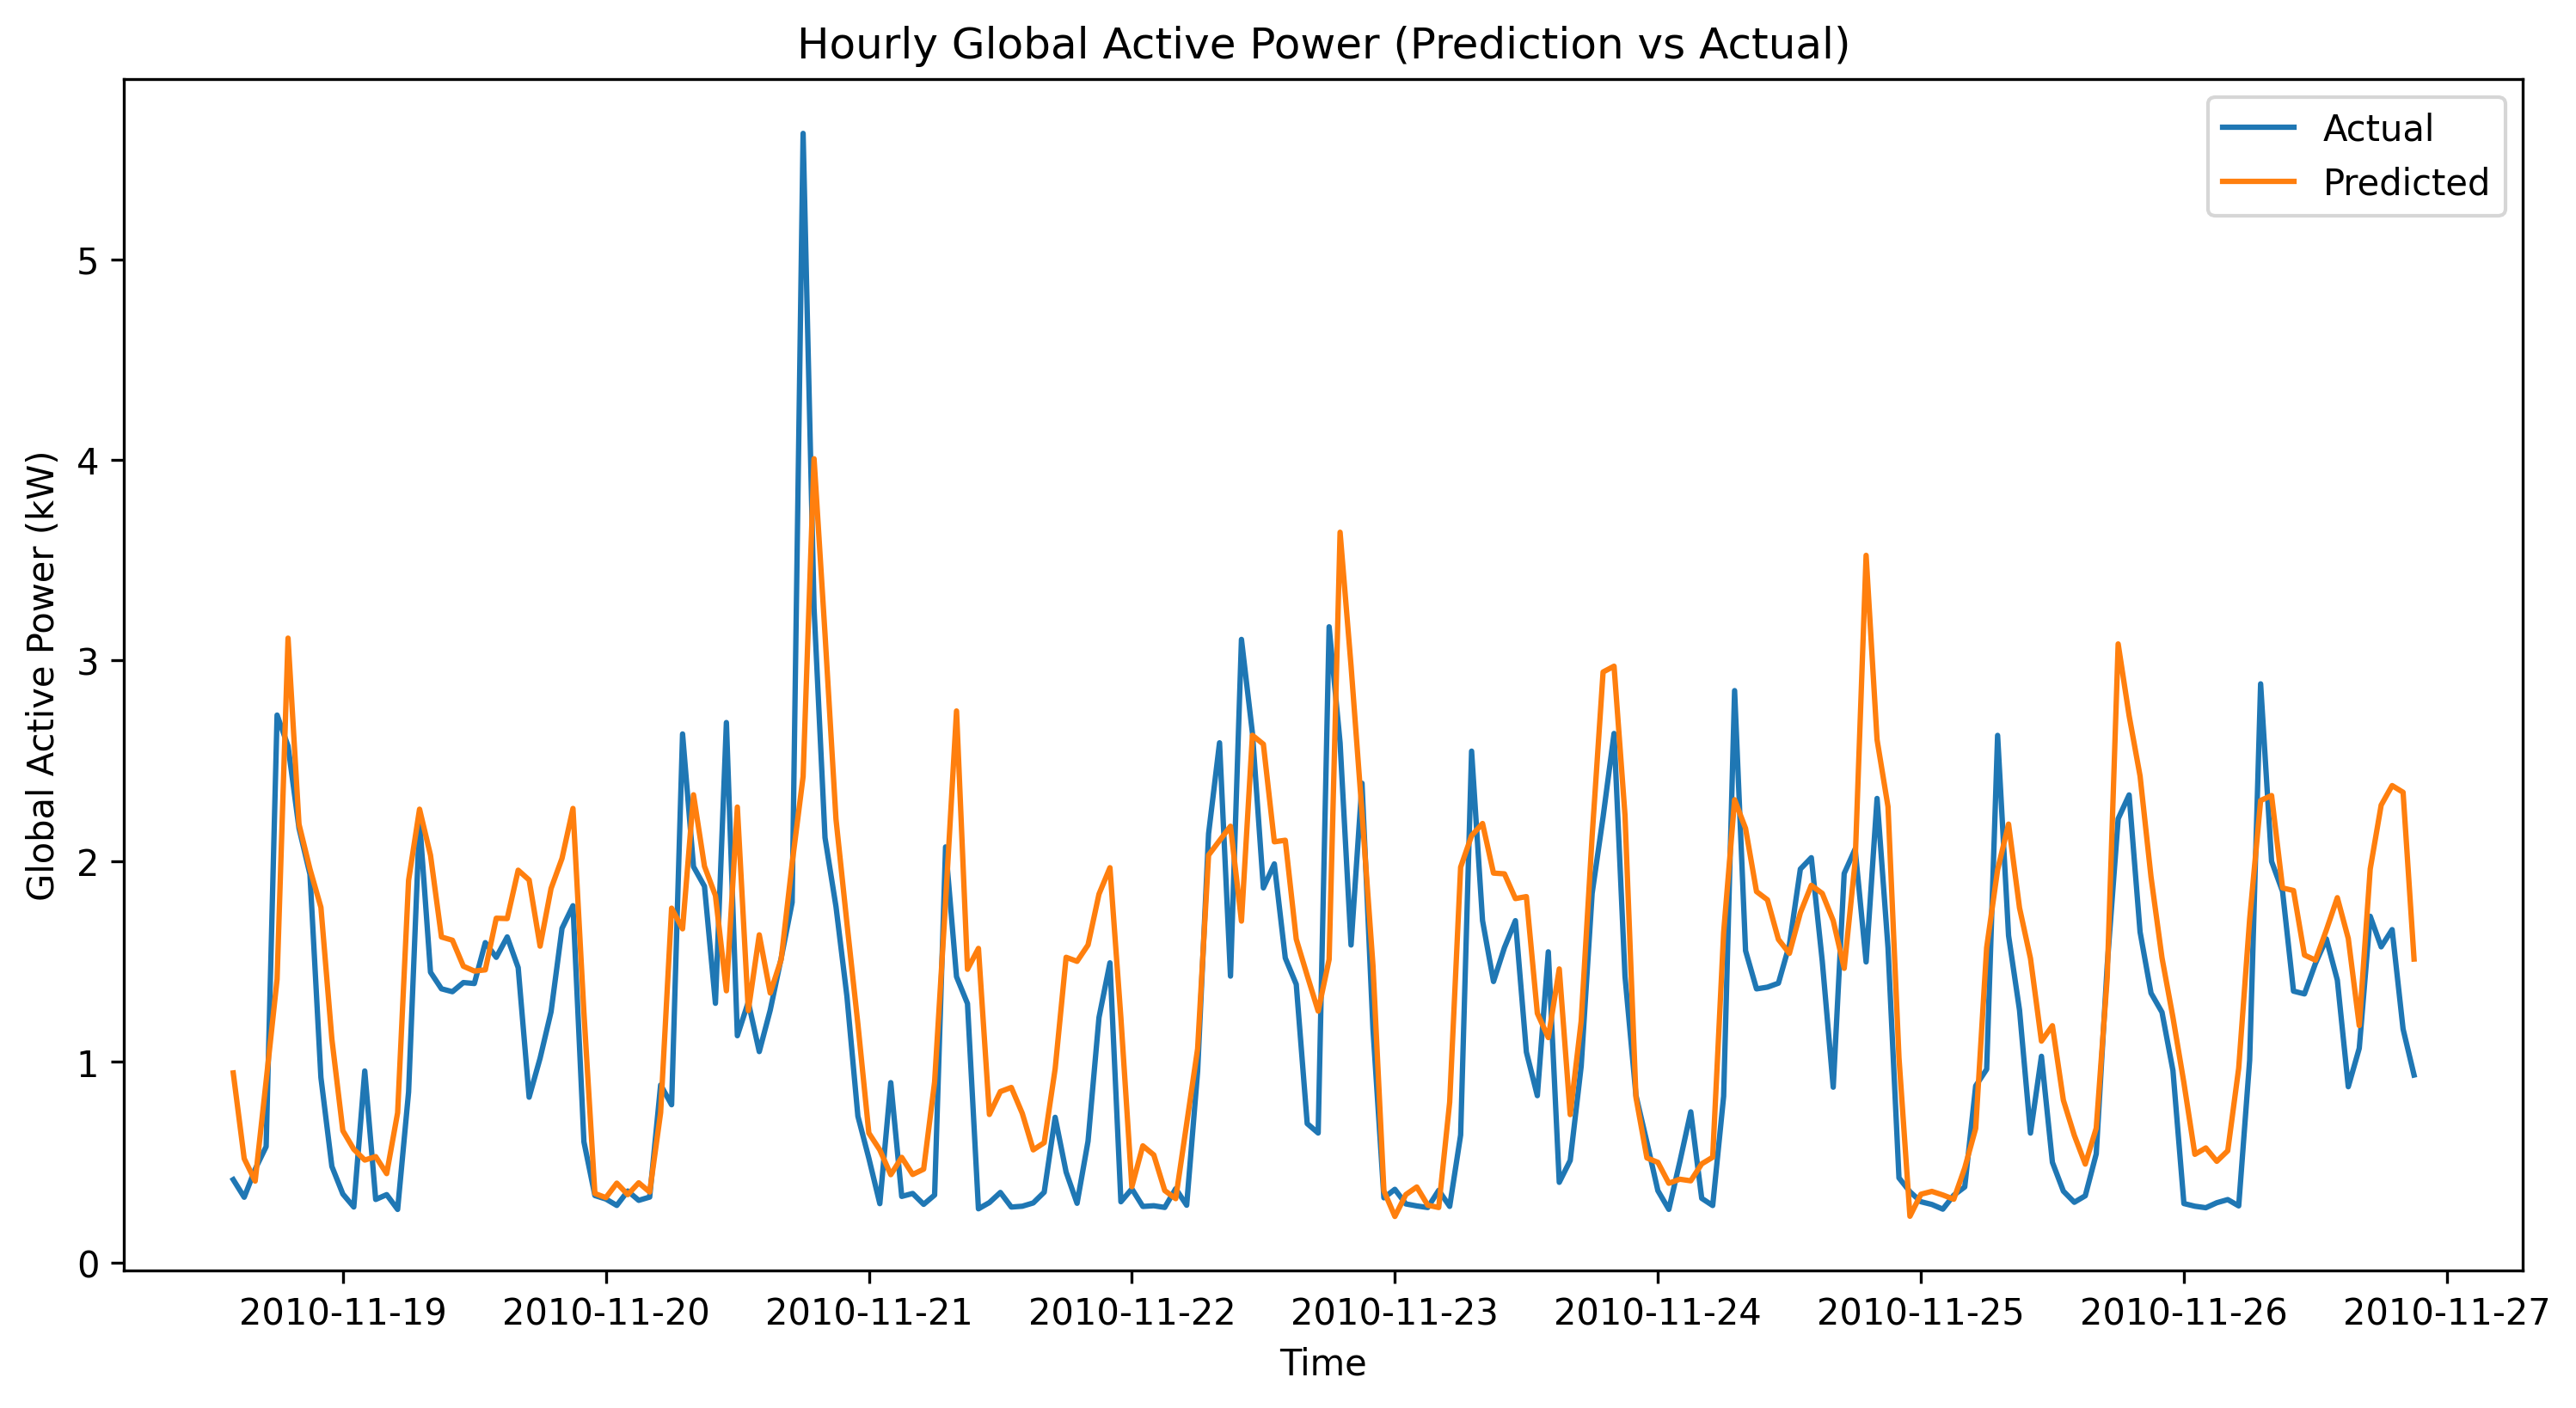

In [18]:
# Define sequence length and features
sequence_length = 24             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-3 Adam(lr=0.0001) seq=24 epochs=50 batch_size=32

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
864/864 - 7s - 8ms/step - loss: 0.0173 - val_loss: 0.0118
Epoch 2/50
864/864 - 4s - 5ms/step - loss: 0.0137 - val_loss: 0.0099
Epoch 3/50
864/864 - 4s - 5ms/step - loss: 0.0120 - val_loss: 0.0095
Epoch 4/50
864/864 - 7s - 8ms/step - loss: 0.0111 - val_loss: 0.0093
Epoch 5/50
864/864 - 9s - 10ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 6/50
864/864 - 6s - 6ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 7/50
864/864 - 4s - 5ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 8/50
864/864 - 5s - 6ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 9/50
864/864 - 6s - 7ms/step - loss: 0.0094 - val_loss: 0.0079
Epoch 10/50
864/864 - 9s - 11ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 11/50
864/864 - 5s - 6ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 12/50
864/864 - 4s - 5ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 13/50
864/864 - 6s - 7ms/step - loss: 0.0089 - val_loss: 0.0073
Epoch 14/50
864/864 - 4s - 5ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 15/50
864/864 - 5s - 

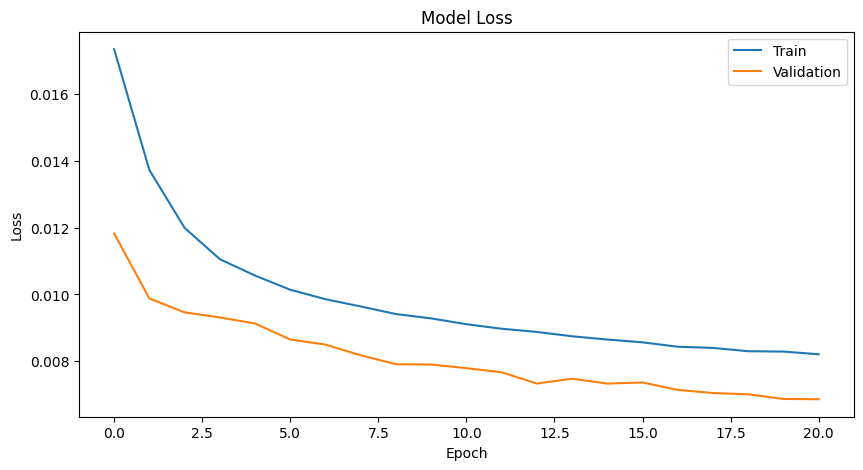

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train MAE: 0.46478294661706204
Train MSE: 0.36171845916632334
Train RMSE: 0.6014303444010148

Test MAE: 0.42072558772270857
Test MSE: 0.28429045768496725
Test RMSE: 0.5331889512030114


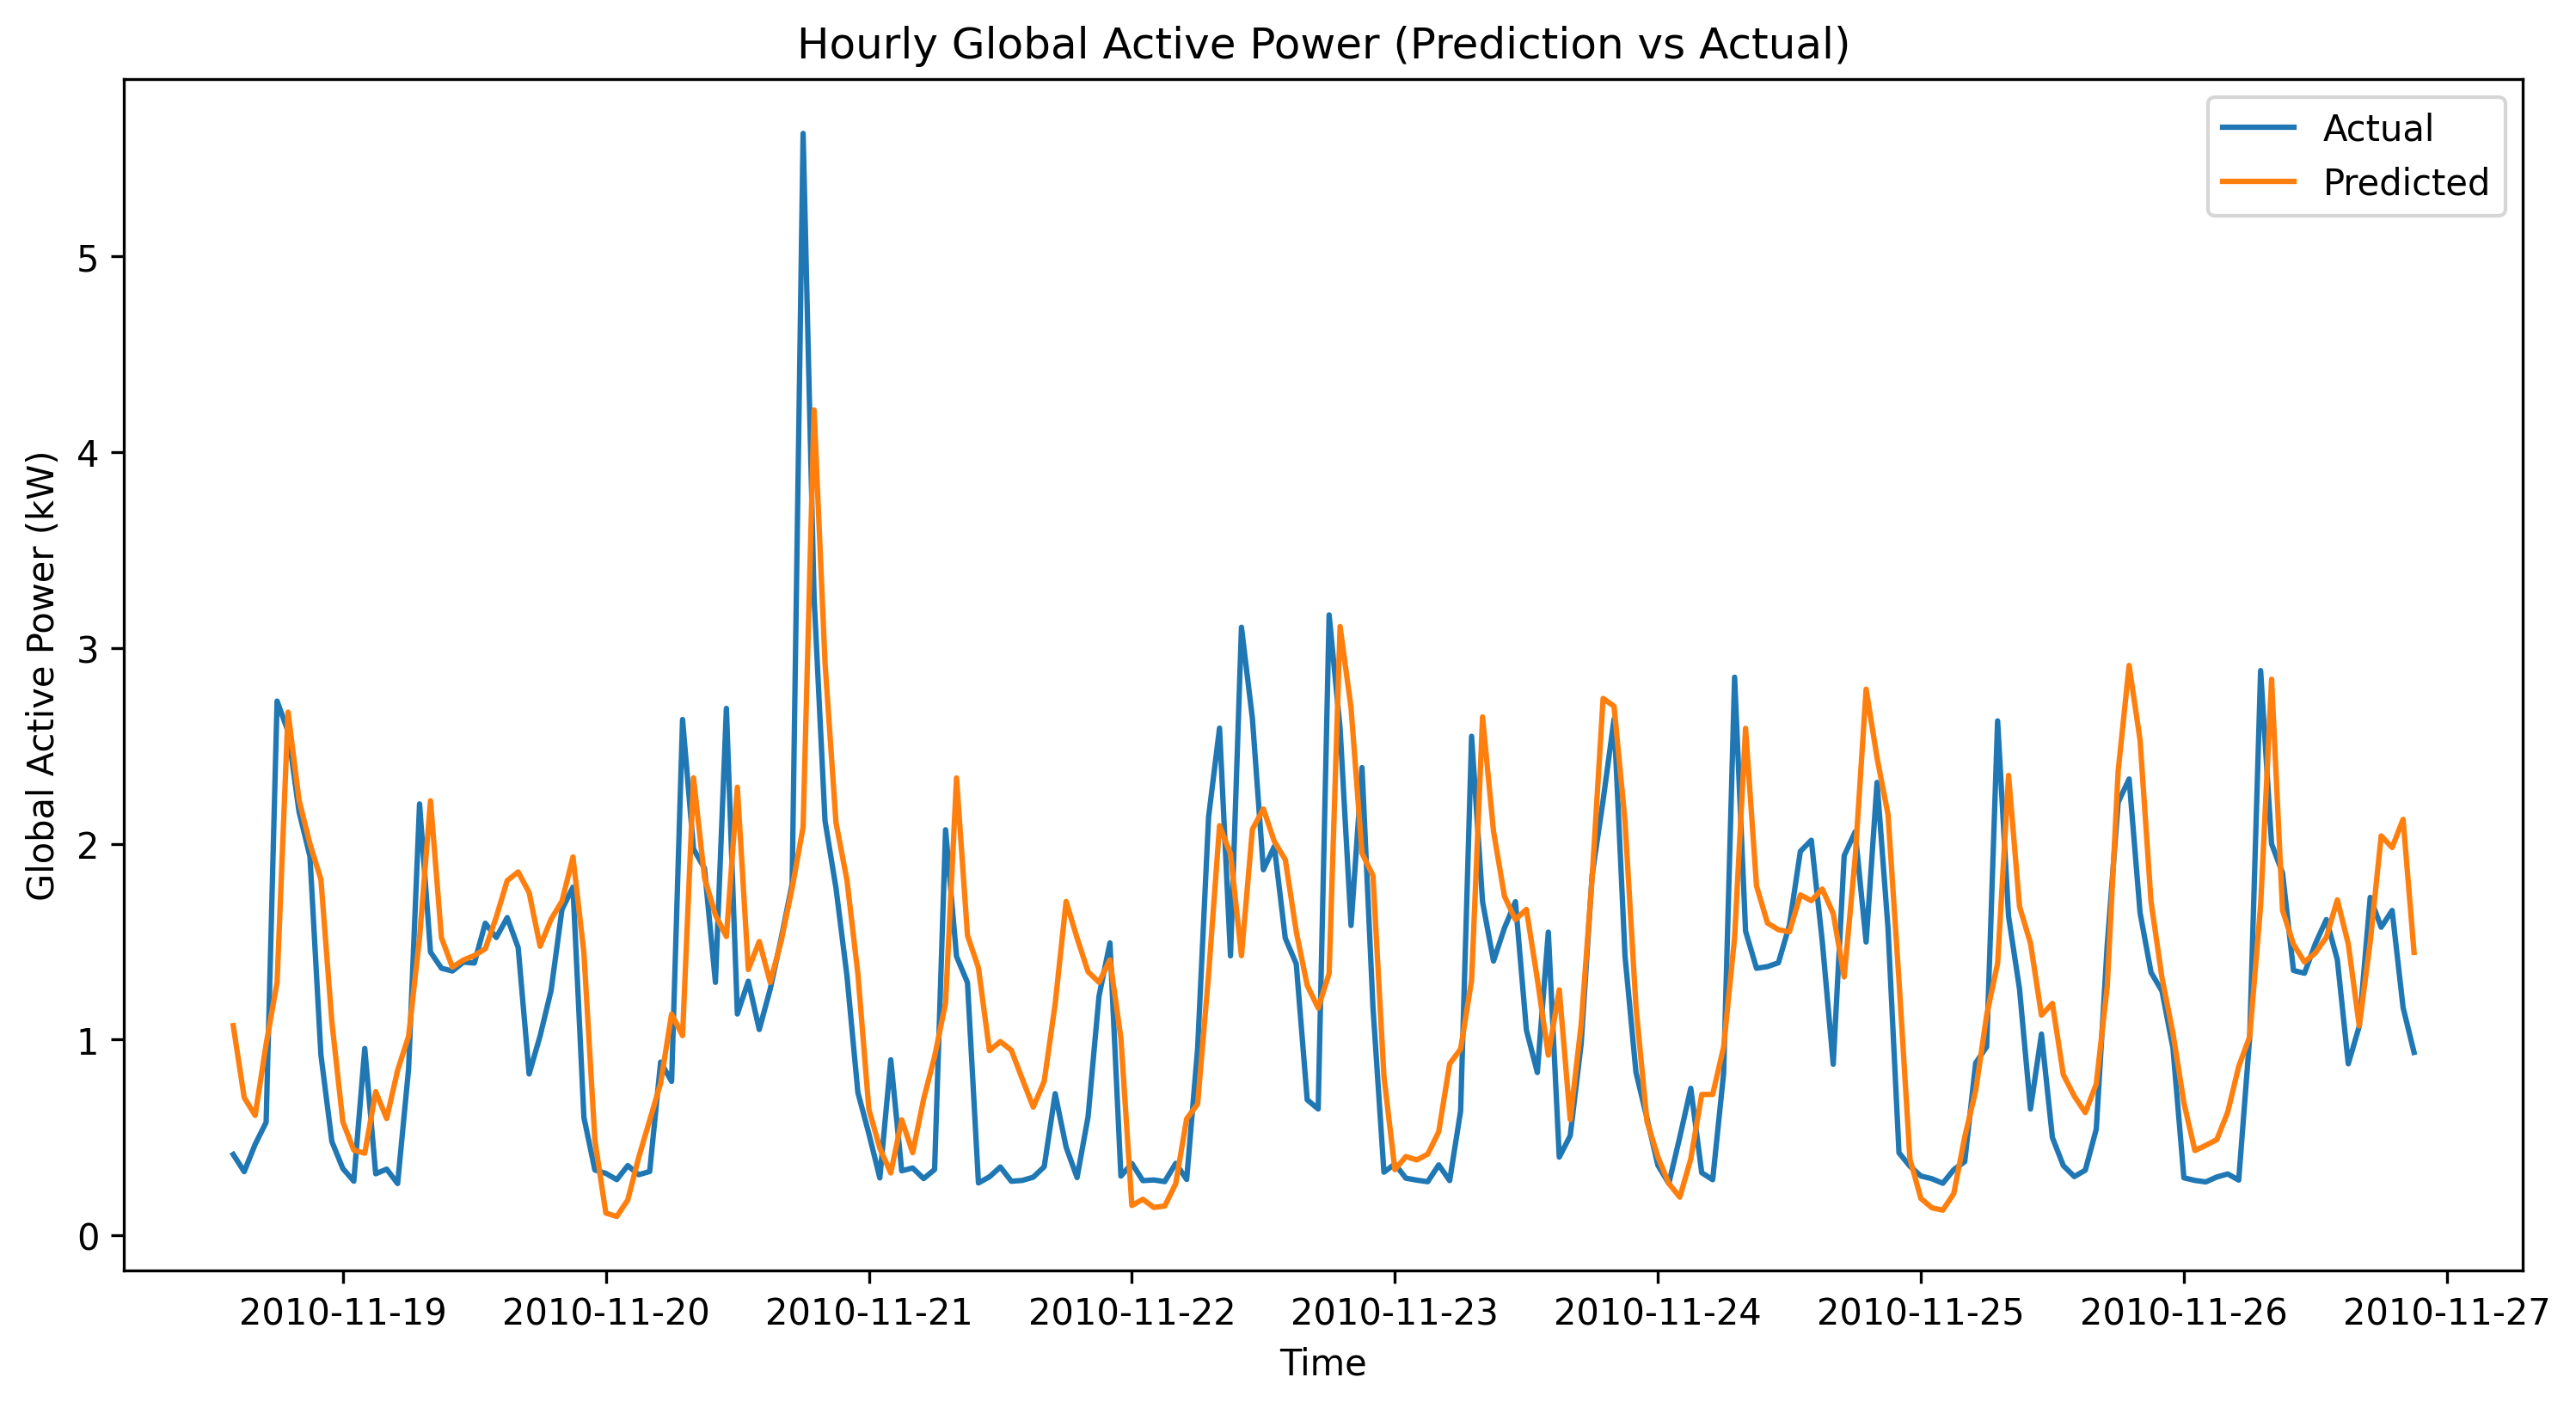

In [19]:
# Define sequence length and features
sequence_length = 48             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Daily resampled data

In [20]:
# Resampled the data
daily_resampled = df_imputed.resample('D').mean()

## EDA

In [21]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Daily resampling of data : (1442, 8) 


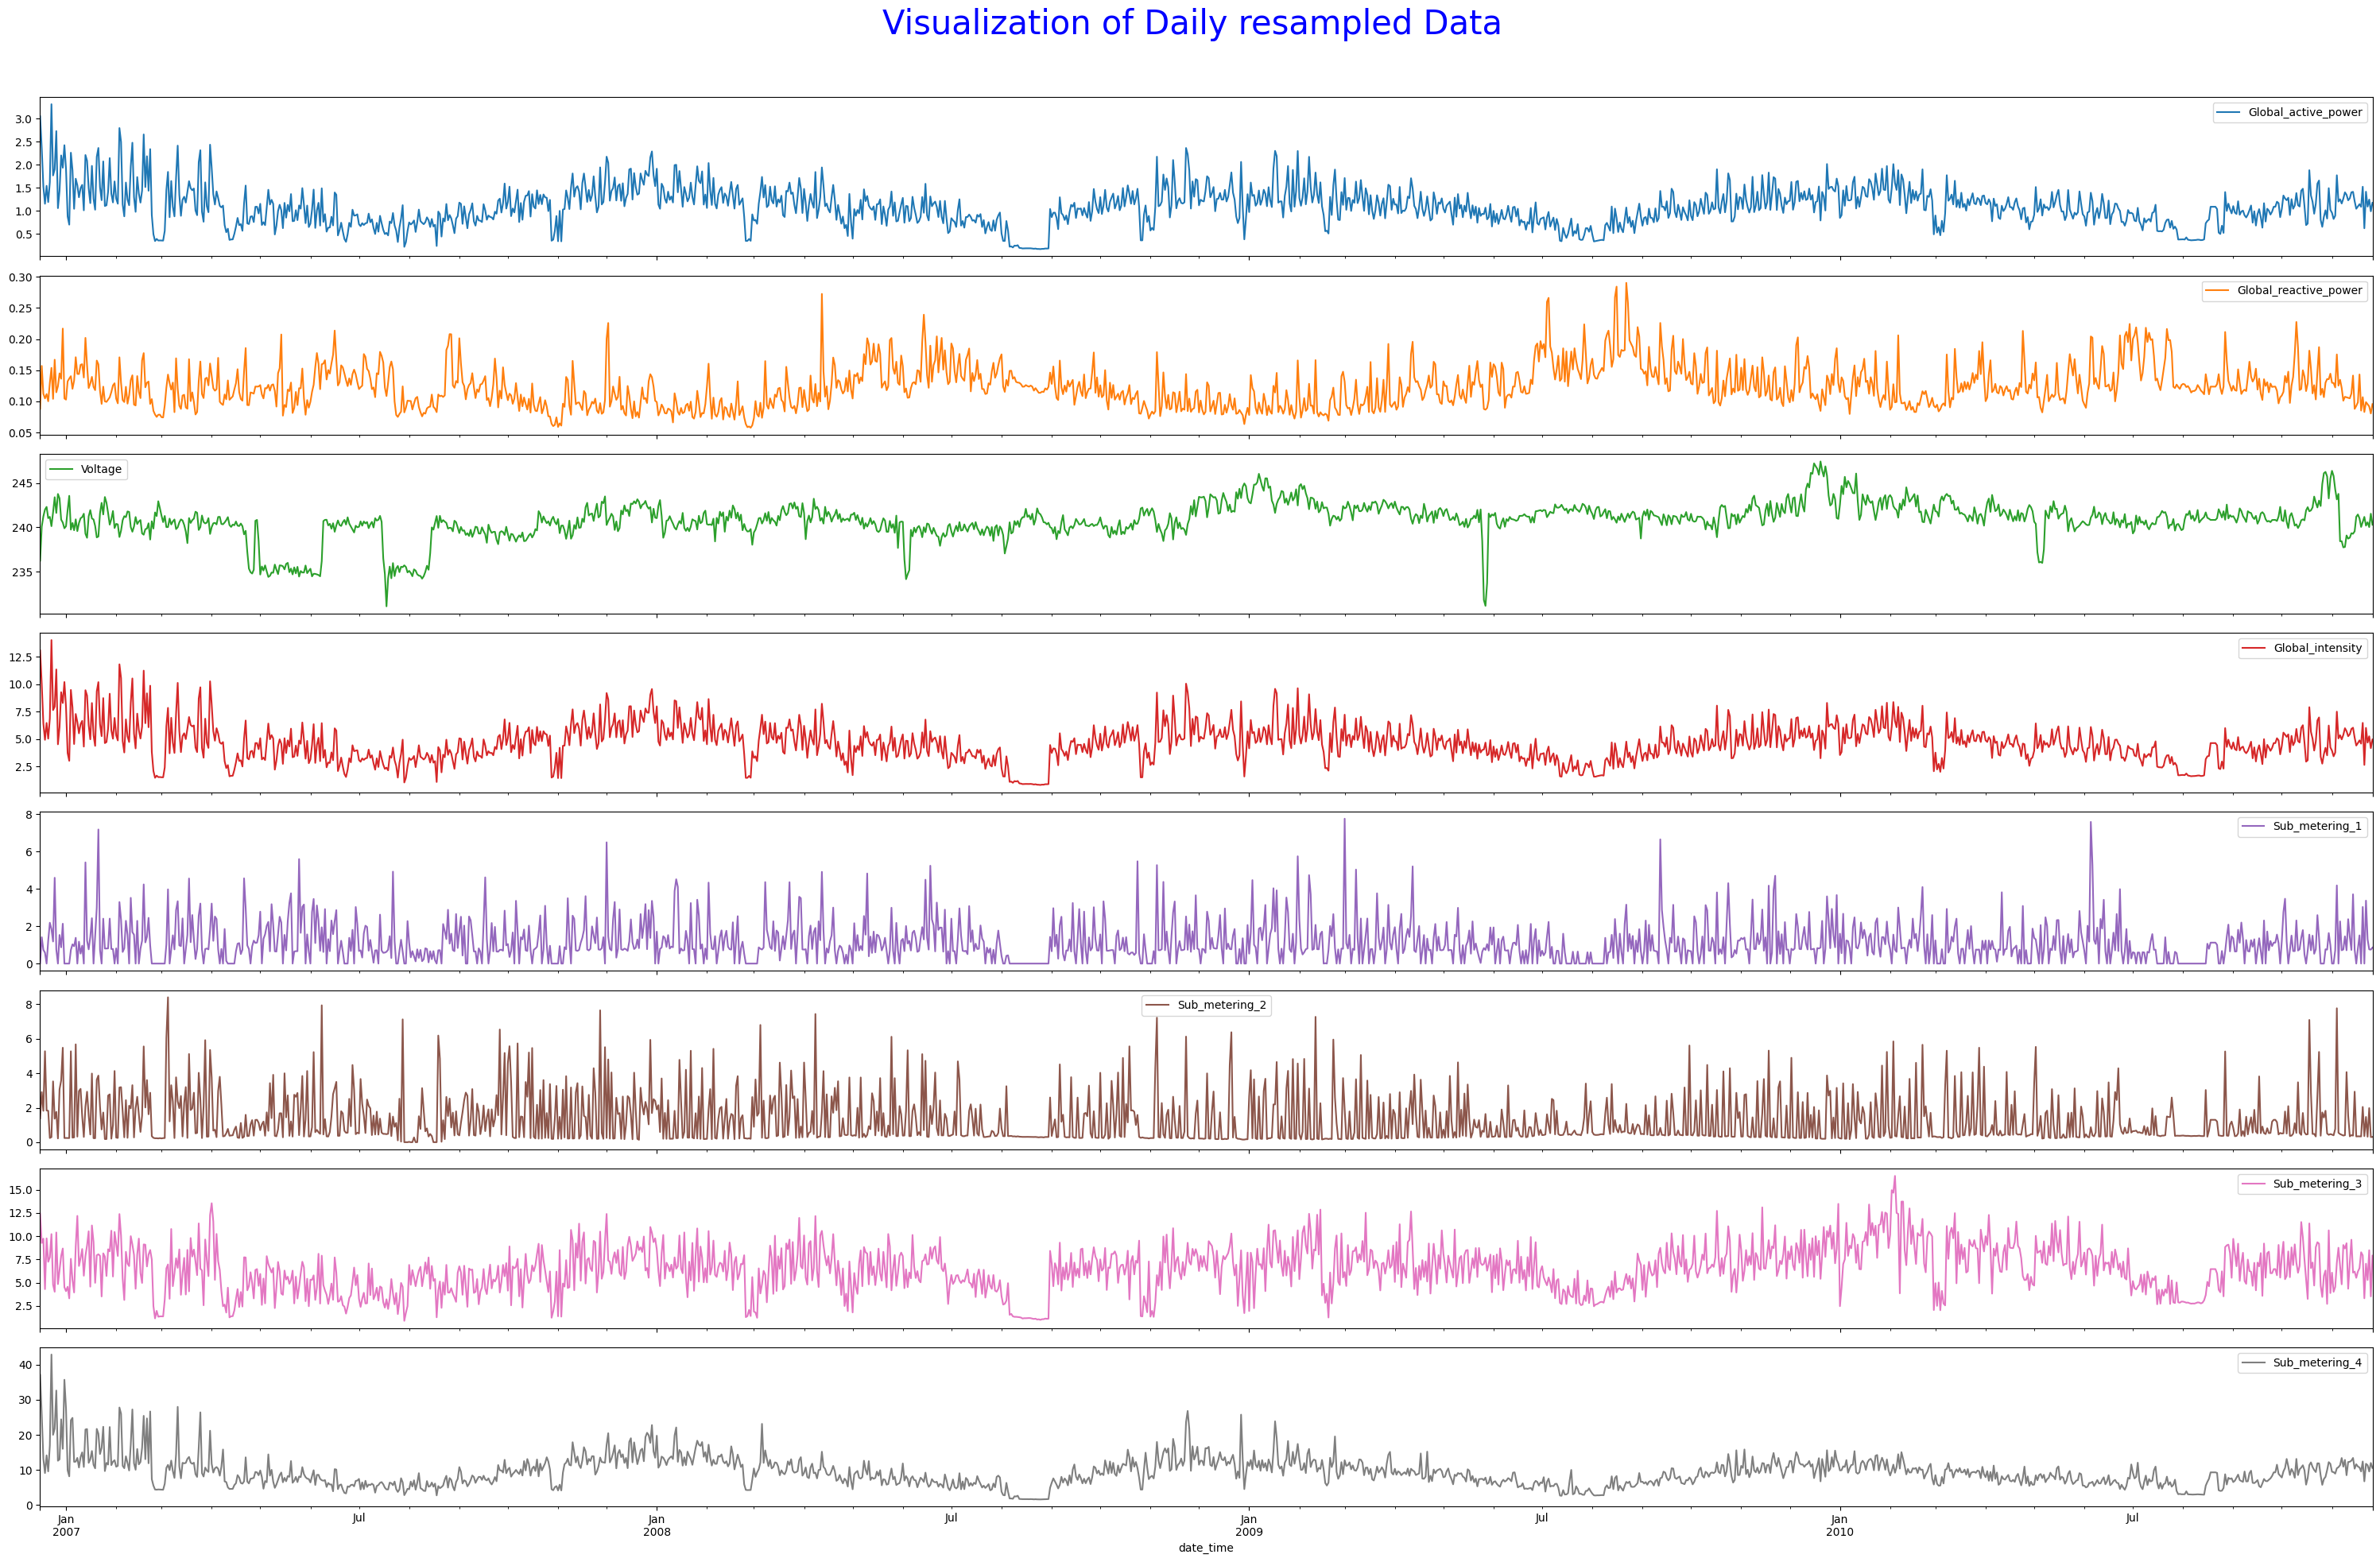

 

************************************************ Daily Resampled distribution Plot **************************************************



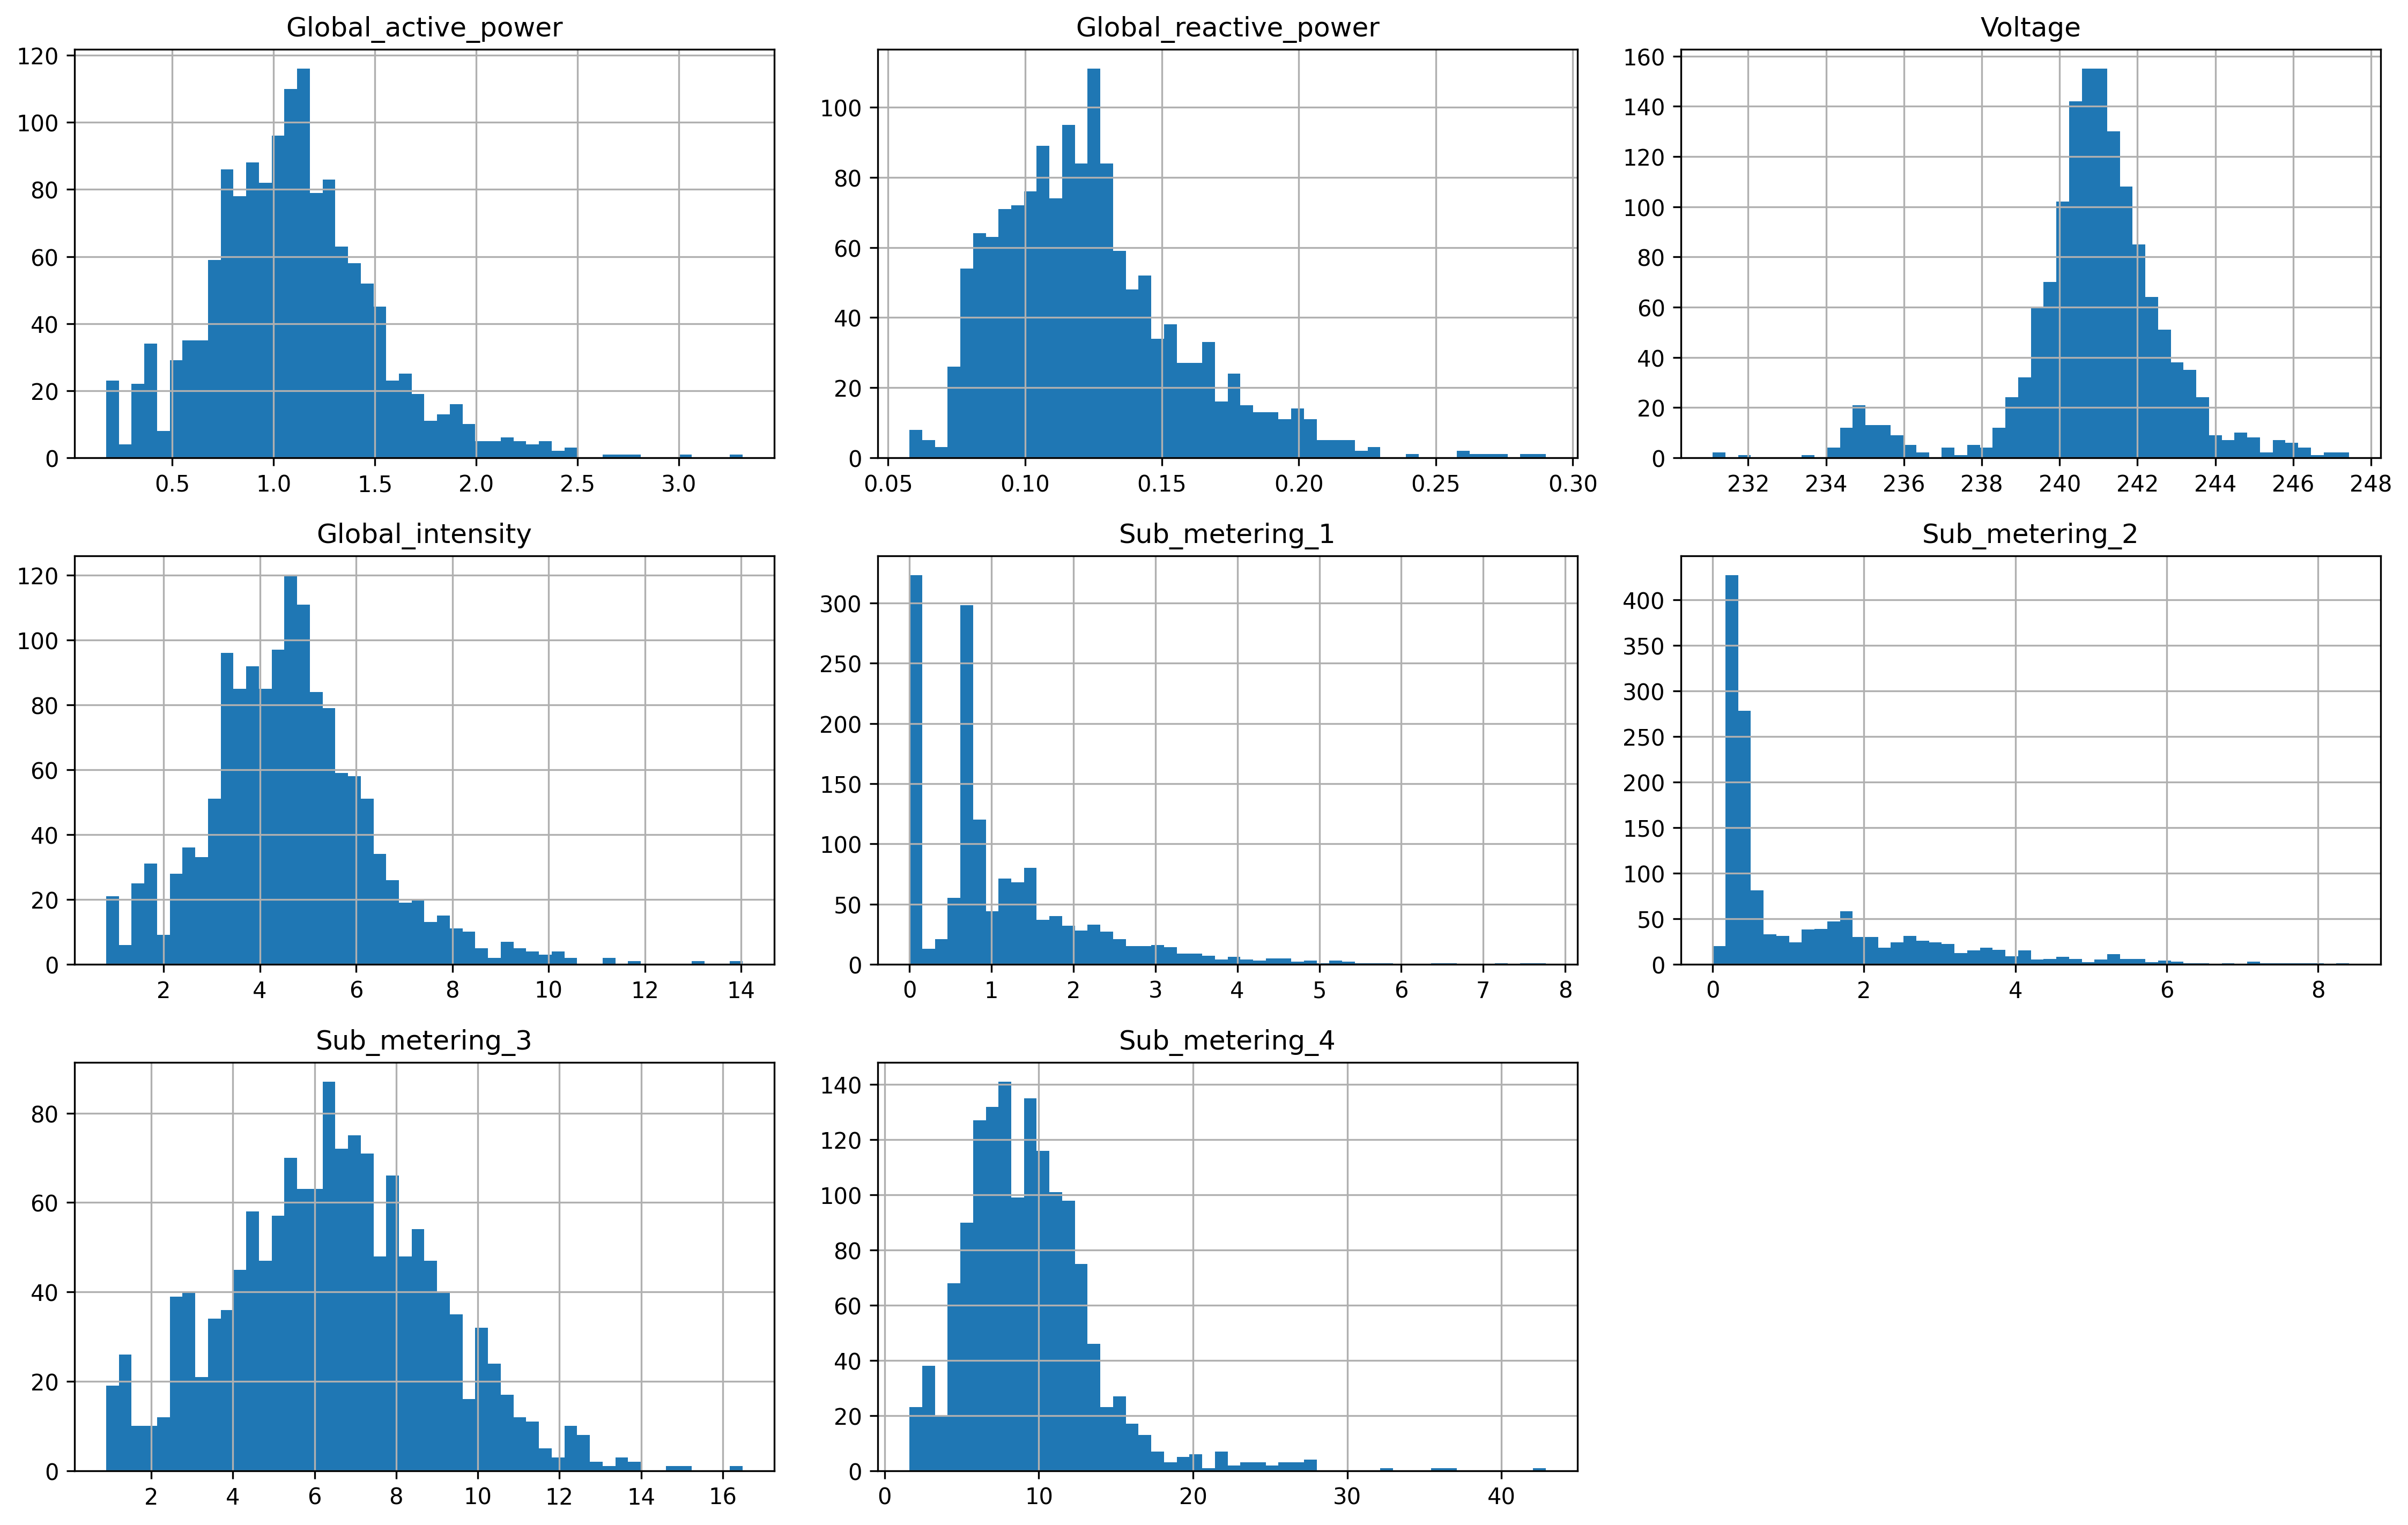

 

************************************************ Correlation Plot for Daily Resampled Data **************************************************



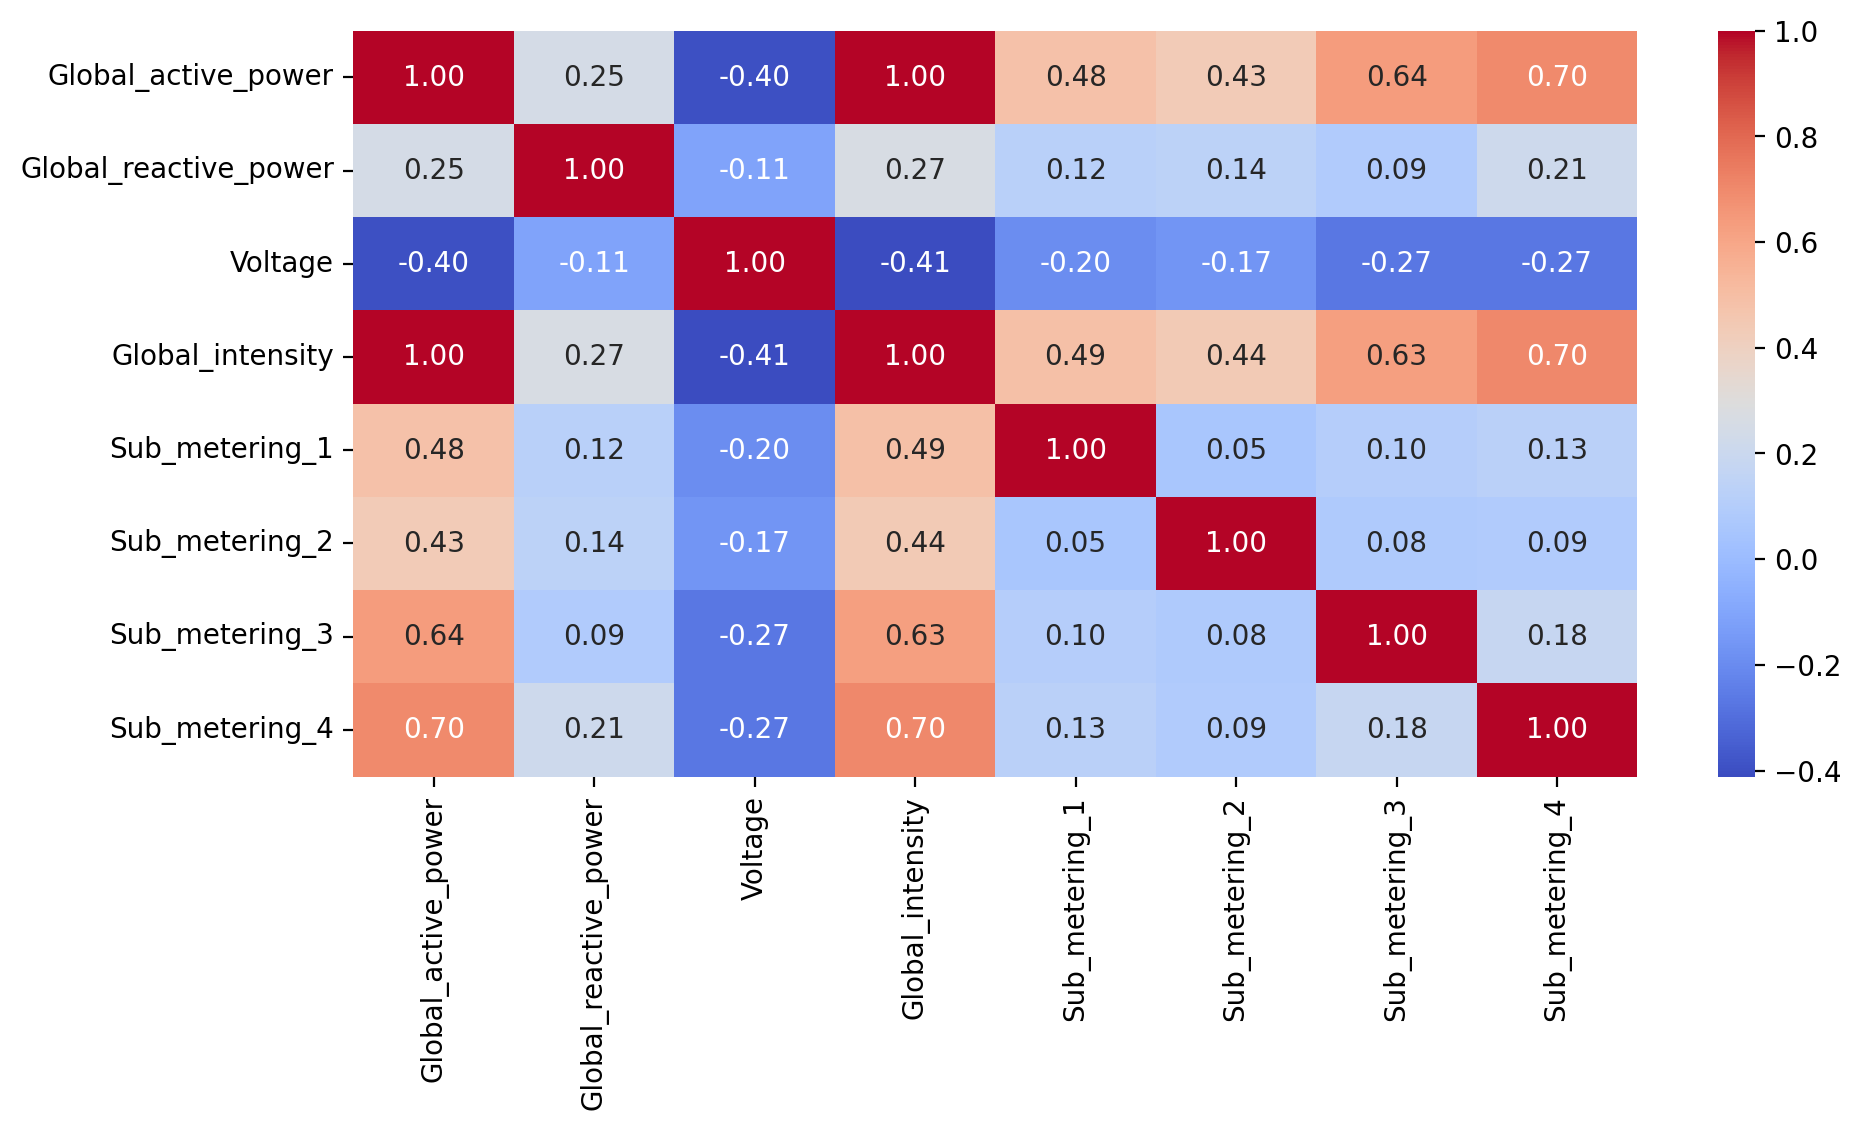

In [22]:
# Plot the visualization, distribution and correlation of Daily resampled data
df_visu_dist_corr(df_imputed, "D", "Daily")

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [23]:
df2 = daily_resampled.drop(['Global_intensity','Sub_metering_4'], axis=1)
df2

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                            
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   
...                         ...                    ...         ...   
2010-11-22             1.417733               0.098857  240.197118   
2010-11-23             1.095511               0.095451  240.575528   
2010-11-24             1.247394               0.091986  240.030965   
2010-11-25             0.993864               0.080644  241.536257   
2010-11-26             1.178230               0.095666  240.291029   

            Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                   
2006-12-16        0.000000        1.378788       12.439394  
2006-12-17        1.411806        2.907639        9.264583  
2006-12-18        0.738194        1.820139        9.734722  
2006-12-19        0.582639        5.279167        4.303472  
2006-12-20        0.000000        1.838889        9.765972  
...                    ...             ...             ...  
2010-11-22        3.371528        1.465278        7.038889  
2010-11-23        1.299306        0.318056        5.285417  
2010-11-24        0.761111        1.977778        8.488889  
2010-11-25        0.747222        0.295833        3.522222  
2010-11-26        0.855107        0.304830        7.908947  

[1442 rows x 6 columns]

## Data Normalization

In [24]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df2 = scaler.fit_transform(df2)

# Shape of scaled data
scaled_df2

array([[0.91678642, 0.13073198, 0.3153853 , 0.        , 0.16396519,
        0.74035748],
       [0.6942518 , 0.42667057, 0.55049373, 0.18185686, 0.34577587,
        0.53676241],
       [0.43190139, 0.23474981, 0.62051772, 0.09508797, 0.21645057,
        0.5669116 ],
       ...,
       [0.34179083, 0.14708326, 0.54706415, 0.0980399 , 0.23519696,
        0.48701848],
       [0.26107518, 0.0982707 , 0.63914907, 0.09625085, 0.03518044,
        0.16851481],
       [0.31977106, 0.16292032, 0.56297334, 0.11014764, 0.0362503 ,
        0.44982782]])

## LSTM-1 Adam(lr=0.01) seq=7 epochs=50 batch_size=32

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 1s - 37ms/step - loss: 0.0373 - val_loss: 0.0094
Epoch 2/50
36/36 - 0s - 5ms/step - loss: 0.0154 - val_loss: 0.0057
Epoch 3/50
36/36 - 0s - 8ms/step - loss: 0.0130 - val_loss: 0.0069
Epoch 4/50
36/36 - 0s - 5ms/step - loss: 0.0127 - val_loss: 0.0059
Epoch 5/50
36/36 - 0s - 5ms/step - loss: 0.0118 - val_loss: 0.0072
Epoch 6/50
36/36 - 0s - 5ms/step - loss: 0.0127 - val_loss: 0.0057
Epoch 7/50
36/36 - 0s - 8ms/step - loss: 0.0121 - val_loss: 0.0058
Epoch 8/50
36/36 - 0s - 8ms/step - loss: 0.0130 - val_loss: 0.0057
Epoch 9/50
36/36 - 0s - 5ms/step - loss: 0.0122 - val_loss: 0.0055
Epoch 10/50
36/36 - 0s - 5ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 11/50
36/36 - 0s - 5ms/step - loss: 0.0117 - val_loss: 0.0054
Epoch 12/50
36/36 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0055
Epoch 13/50
36/36 - 0s - 8ms/step - loss: 0.0124 - val_loss: 0.0055
Epoch 14/50
36/36 - 0s - 5ms/step - loss: 0.0121 - val_loss: 0.0055
Epoch 15/50
36/36 - 0s - 8ms/step - loss: 0.0118 - val_l

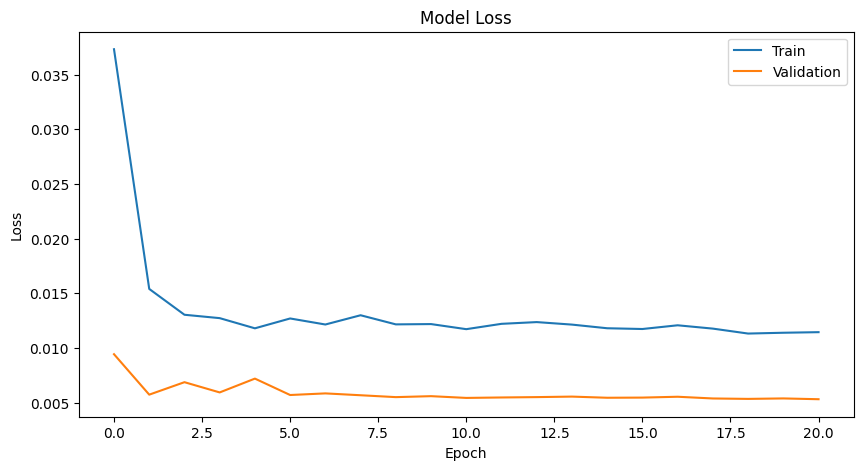

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MAE: 0.2415156998667685
Train MSE: 0.11281332601609588
Train RMSE: 0.33587695070679663

Test MAE: 0.1737535764623038
Test MSE: 0.05232909386792445
Test RMSE: 0.2287555329777281


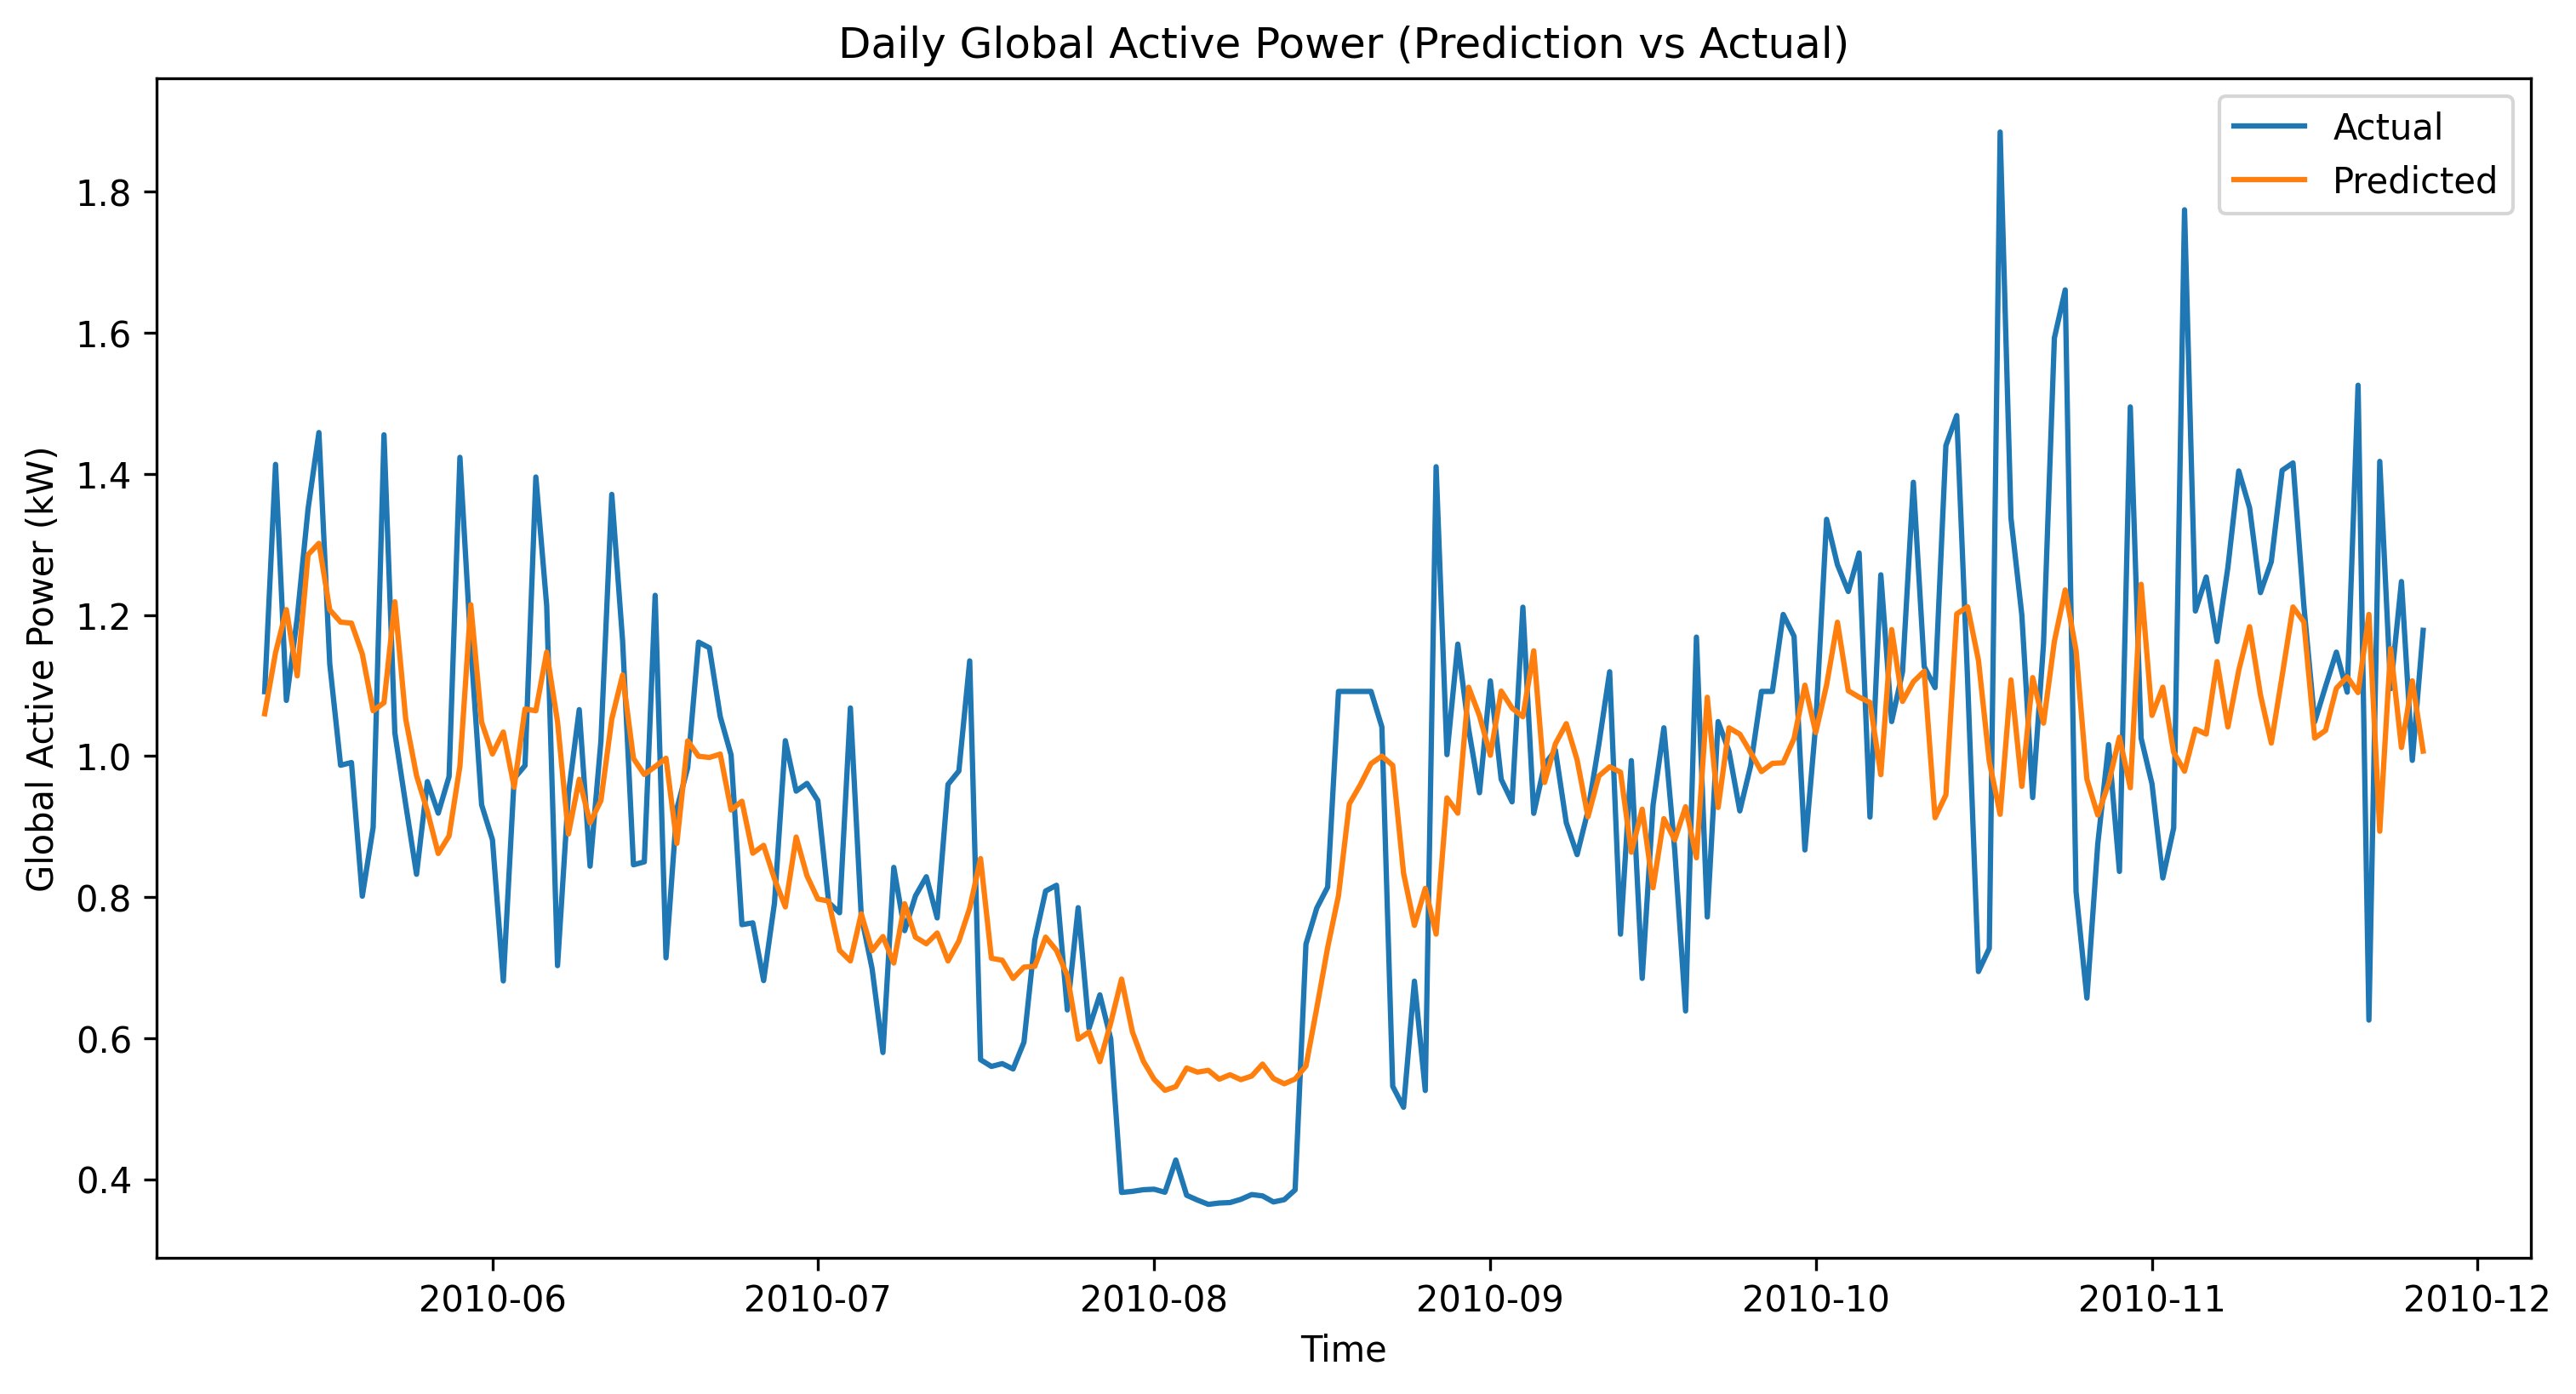

In [25]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-2 Adam(lr=0.001) seq=7 epochs=50 batch_size=32

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 2s - 62ms/step - loss: 0.0288 - val_loss: 0.0063
Epoch 2/50
36/36 - 0s - 7ms/step - loss: 0.0130 - val_loss: 0.0066
Epoch 3/50
36/36 - 0s - 8ms/step - loss: 0.0129 - val_loss: 0.0063
Epoch 4/50
36/36 - 0s - 8ms/step - loss: 0.0119 - val_loss: 0.0061
Epoch 5/50
36/36 - 0s - 8ms/step - loss: 0.0120 - val_loss: 0.0060
Epoch 6/50
36/36 - 0s - 5ms/step - loss: 0.0119 - val_loss: 0.0060
Epoch 7/50
36/36 - 0s - 12ms/step - loss: 0.0115 - val_loss: 0.0058
Epoch 8/50
36/36 - 1s - 17ms/step - loss: 0.0117 - val_loss: 0.0058
Epoch 9/50
36/36 - 1s - 17ms/step - loss: 0.0117 - val_loss: 0.0058
Epoch 10/50
36/36 - 1s - 19ms/step - loss: 0.0114 - val_loss: 0.0058
Epoch 11/50
36/36 - 1s - 20ms/step - loss: 0.0112 - val_loss: 0.0055
Epoch 12/50
36/36 - 1s - 16ms/step - loss: 0.0113 - val_loss: 0.0055
Epoch 13/50
36/36 - 1s - 15ms/step - loss: 0.0109 - val_loss: 0.0055
Epoch 14/50
36/36 - 0s - 11ms/step - loss: 0.0110 - val_loss: 0.0056
Epoch 15/50
36/36 - 0s - 10ms/step - loss: 0.011

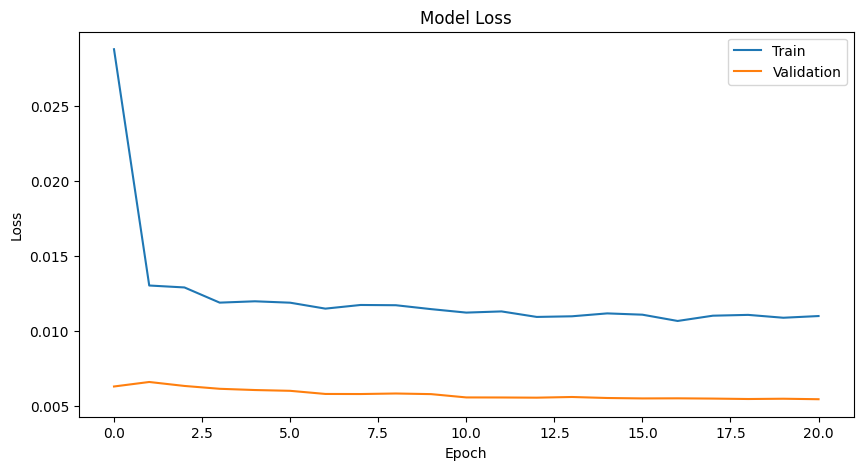

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MAE: 0.2335451415064893
Train MSE: 0.10070279765017405
Train RMSE: 0.31733704109380934

Test MAE: 0.1727524674179744
Test MSE: 0.05357581488143772
Test RMSE: 0.2314645002617847


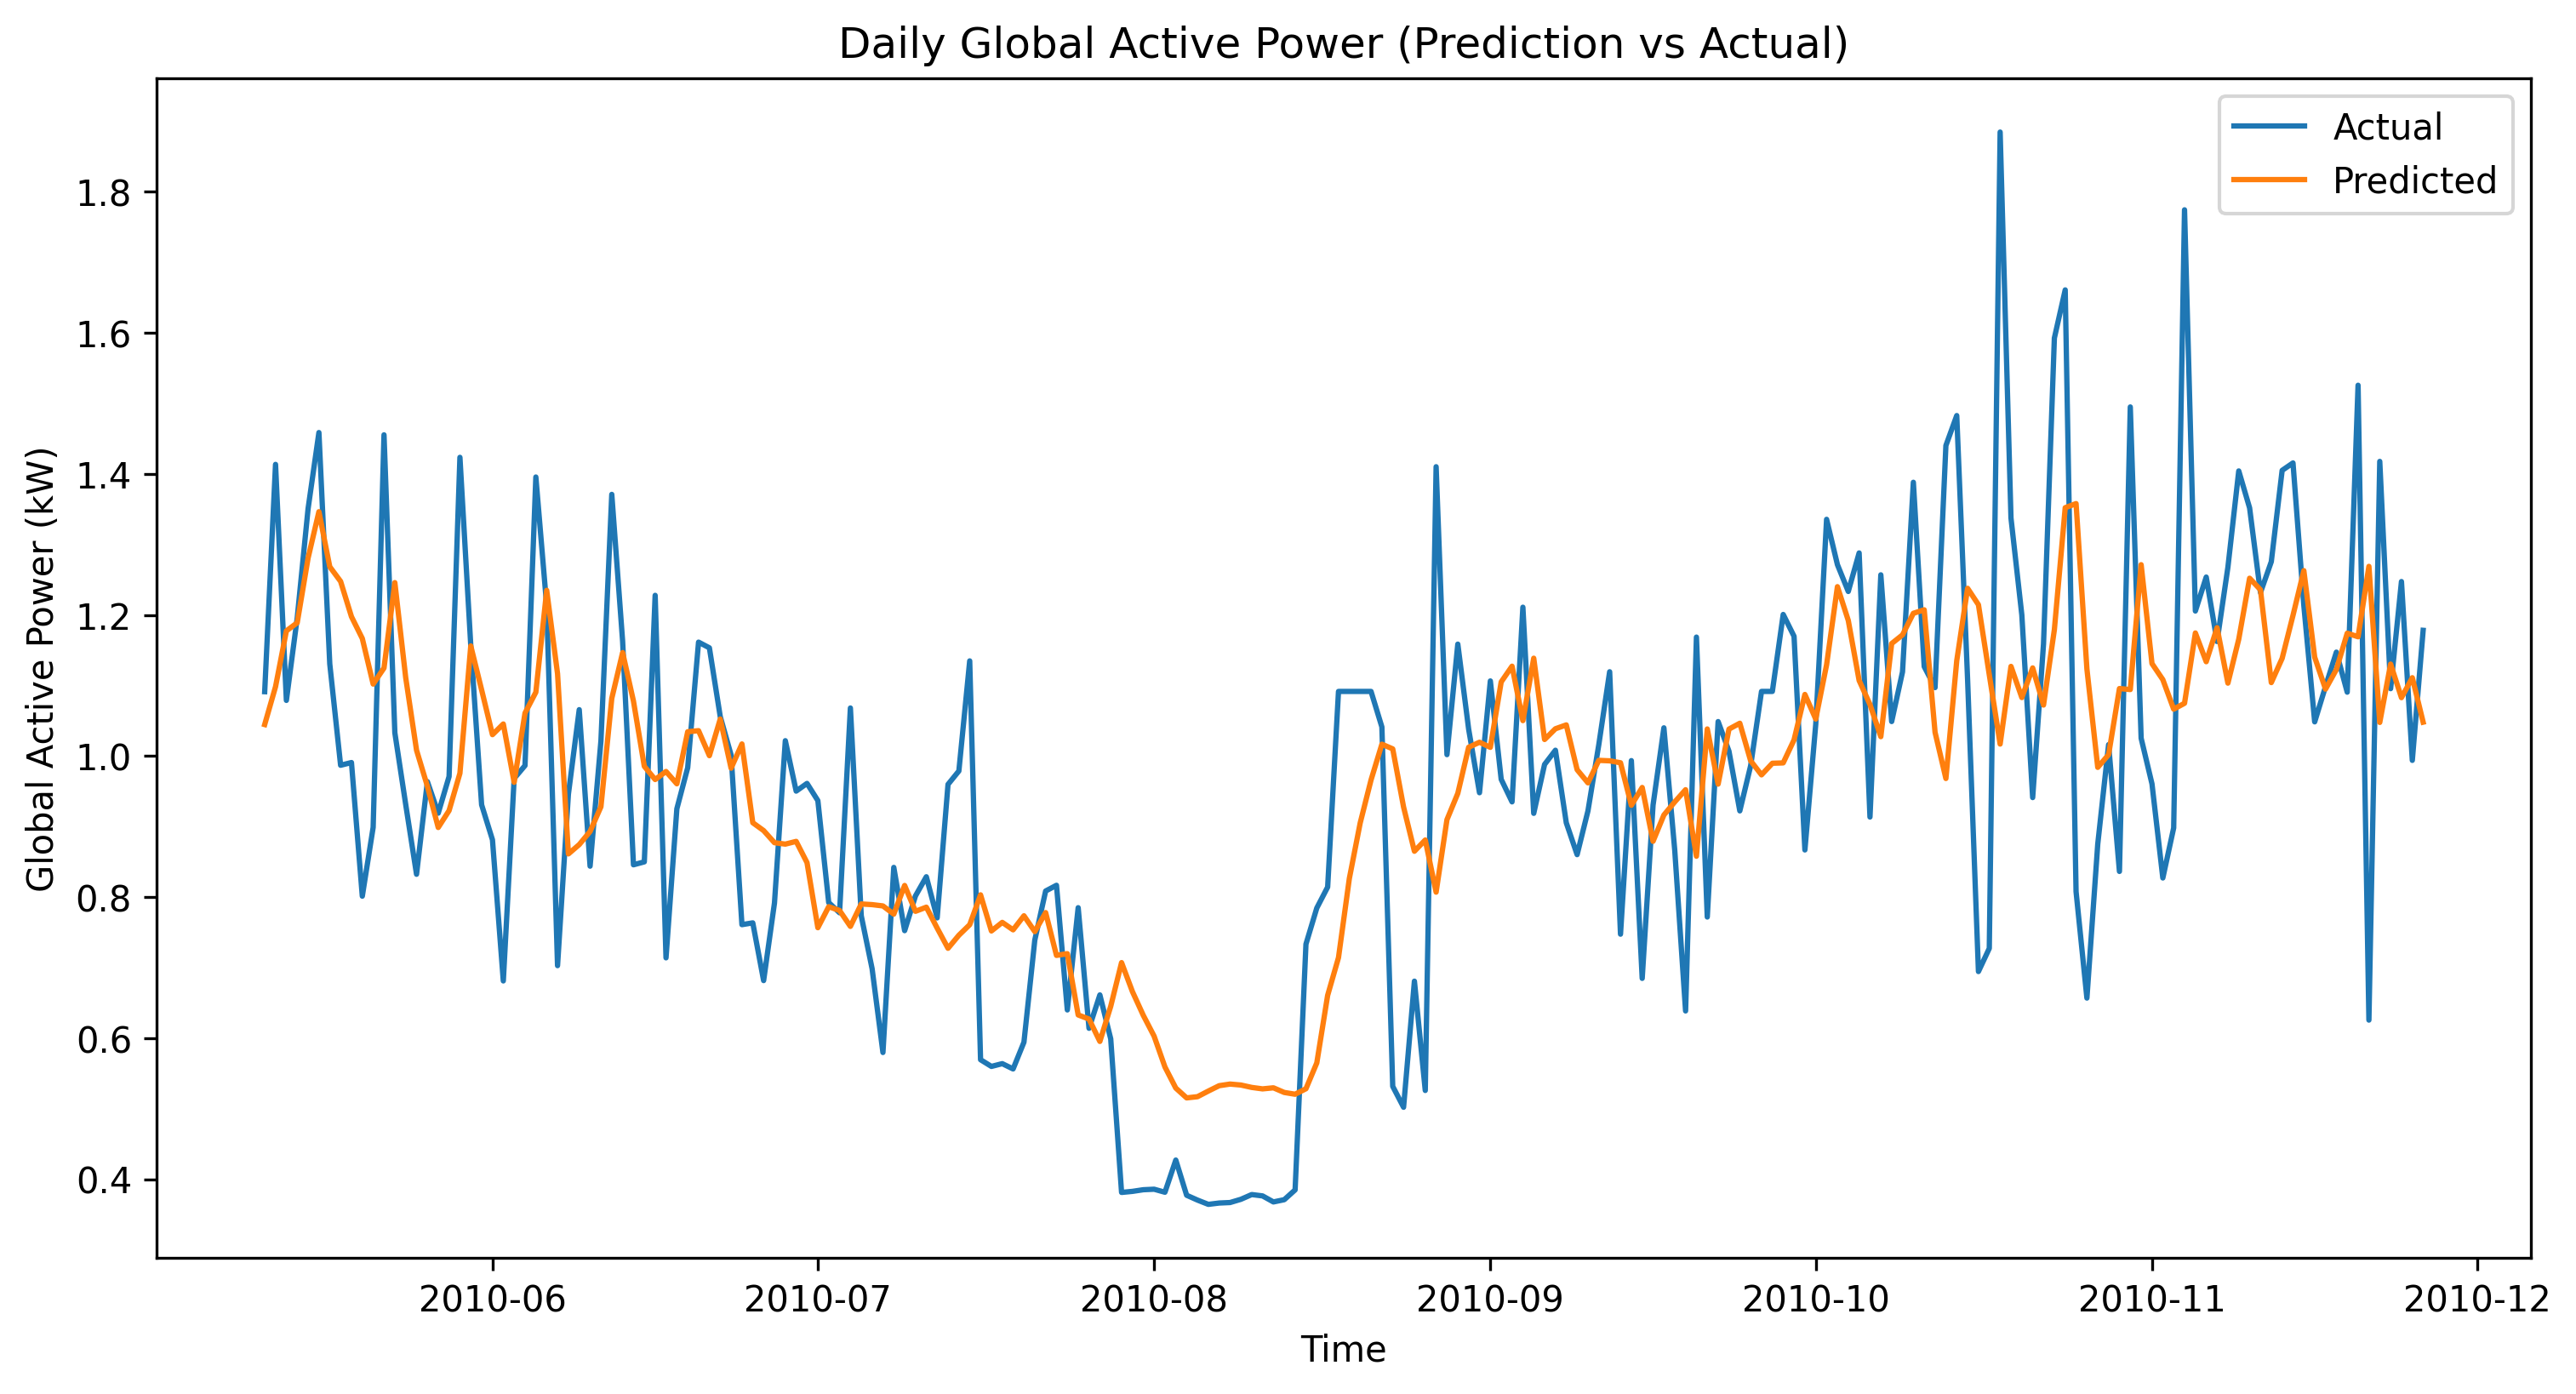

In [26]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df2.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df2) - sequence_length):
    seq = scaled_df2[i:i+sequence_length]
    label = scaled_df2[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df2.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df2.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Daily Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## LSTM-3 Adam(lr=0.0001) seq=7 epochs=50 batch_size=32

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
865/865 - 6s - 7ms/step - loss: 0.0172 - val_loss: 0.0115
Epoch 2/50
865/865 - 4s - 4ms/step - loss: 0.0134 - val_loss: 0.0106
Epoch 3/50
865/865 - 5s - 6ms/step - loss: 0.0121 - val_loss: 0.0099
Epoch 4/50
865/865 - 5s - 6ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 5/50
865/865 - 3s - 4ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 6/50
865/865 - 6s - 7ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 7/50
865/865 - 5s - 6ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 8/50
865/865 - 4s - 5ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 9/50
865/865 - 7s - 8ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 10/50
865/865 - 3s - 4ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 11/50
865/865 - 5s - 6ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 12/50
865/865 - 7s - 8ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 13/50
865/865 - 4s - 4ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 14/50
865/865 - 5s - 6ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 15/50
865/865 - 6s - 7m

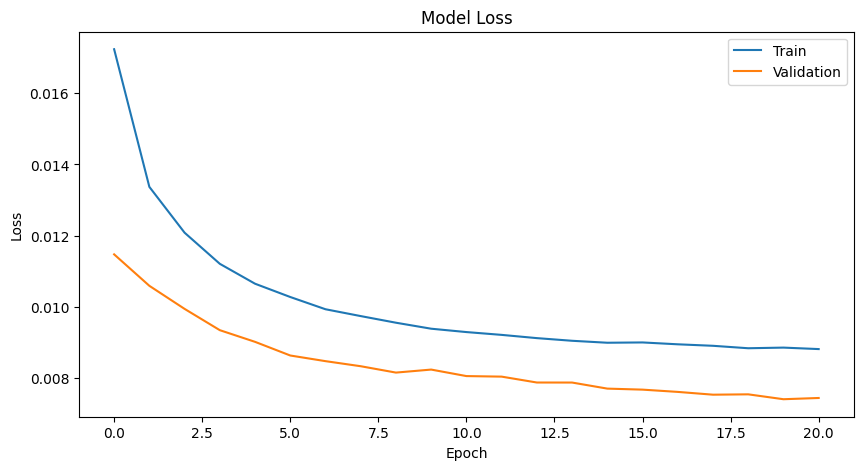

865/865 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MAE: 0.23579574950530716
Train MSE: 0.09277266238906996
Train RMSE: 0.30458605087736695

Test MAE: 0.21468552056807721
Test MSE: 0.07347128599252195
Test RMSE: 0.27105587245533336


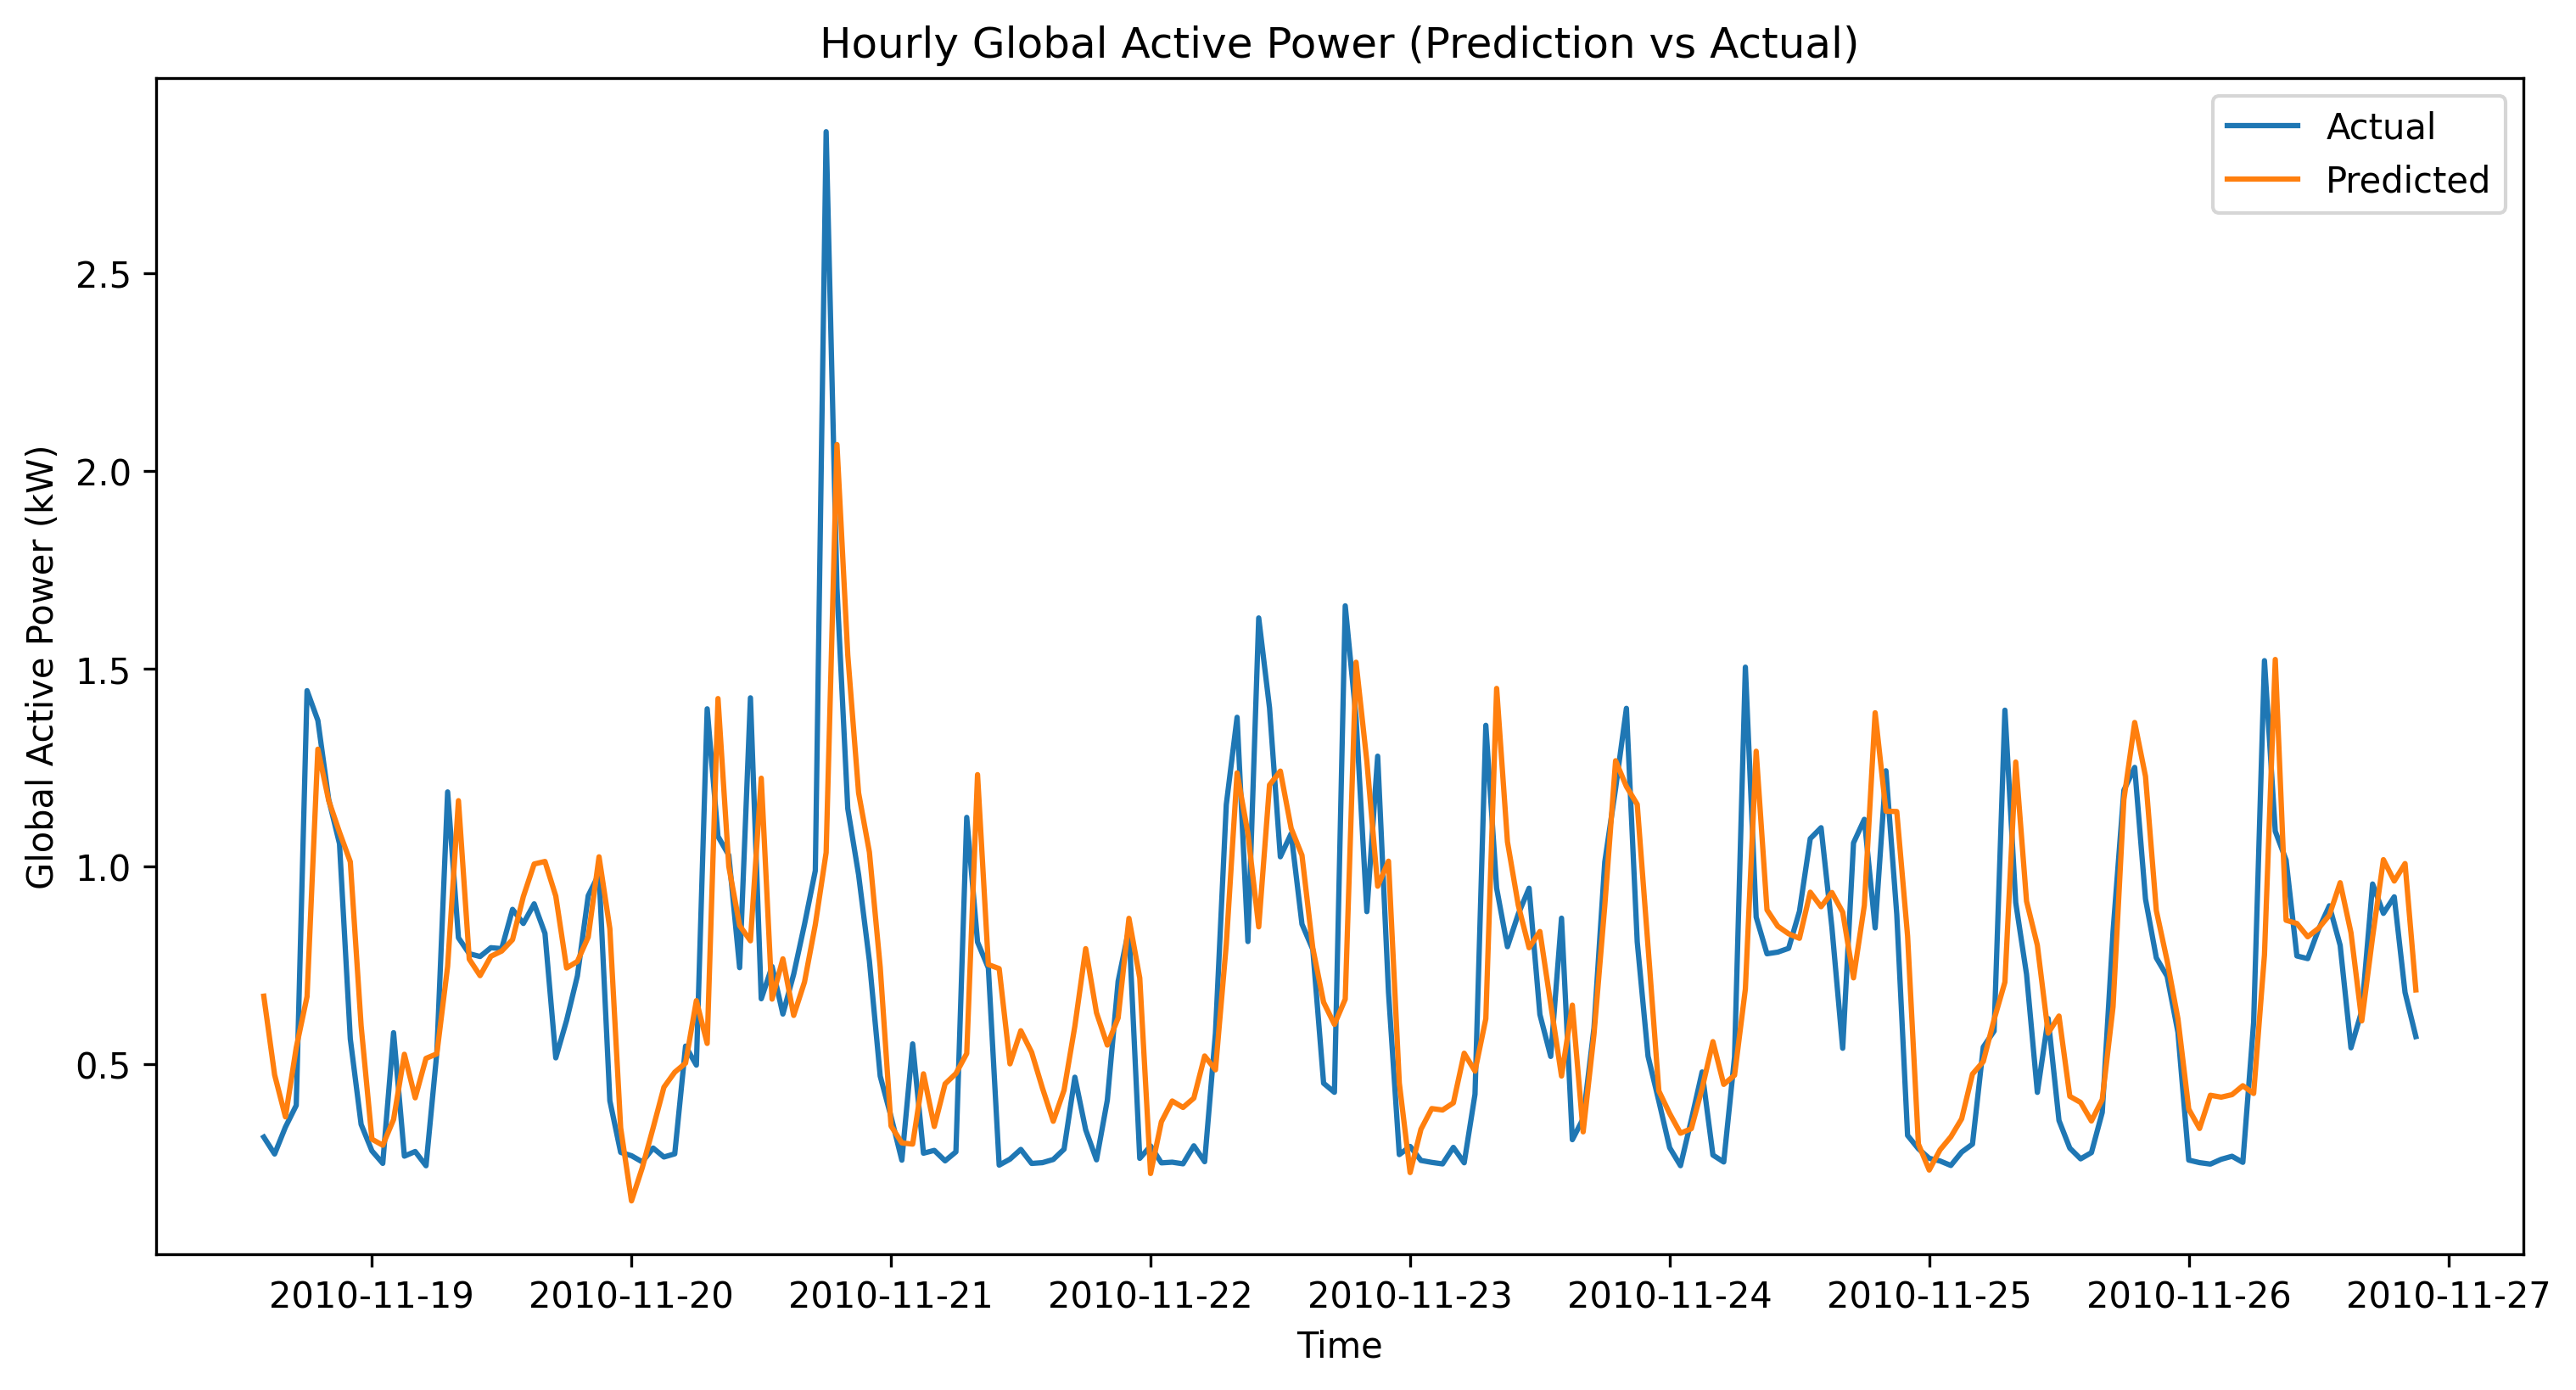

In [27]:
# Define sequence length and features
sequence_length = 7             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20 , min_delta=0.005)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
train_y_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_train_y = scaler.inverse_transform(train_y_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[-1], axis=-1)
pred_train_y = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
test_y_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_test_y = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[-1], axis=-1)
pred_test_y = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print('Train MAE:', mean_absolute_error(true_train_y, pred_train_y))
print('Train MSE:', mean_squared_error(true_train_y, pred_train_y))
print('Train RMSE:',np.sqrt(mean_squared_error(true_train_y, pred_train_y)))

print('\nTest MAE:', mean_absolute_error(true_test_y, pred_test_y))
print('Test MSE:', mean_squared_error(true_test_y, pred_test_y))
print('Test RMSE:',np.sqrt(mean_squared_error(true_test_y, pred_test_y)))

# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_test_y[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_test_y[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()